# Resolution of a problem of irrigation water estimation using the shooting method in dimension 2
## Introduction

---

### But
For given $A\in\mathcal{M}_2(\mathbb{R})$, $G_2\in\mathcal{M}_2(\mathbb{R})$, $C\in\mathcal{M}_2(\mathbb{R})$, and $q_1,q_2>0$ considered ponderation weights, we want to construct the optimal pair
```math
\begin{aligned}
h^\star(t) &= -\tfrac{1}{q_2} G_2^\top p(t),\\
z(0) &= -\tfrac{1}{q_1} p(0)
\end{aligned}
```
where $(z,p)$ is solution of the optimality system  given by the TPBVP:
```math
\begin{aligned}
z'(t) &= A z(t) + G_2 h^\star(t) = A z(t) - \tfrac{1}{q_2} G_2 G_2^\top p(t), \quad z(0) = -\tfrac{1}{q_1} s,\\
p'(t) &= -A^\top p(t) - C^\top\!\big(C z(t) - y^{\mathrm m}(t)\big), \quad p(T)=0,
\end{aligned}
```
and $s := p(0)\in\mathbb{R}^2$ is **the shoot unknown**.  

---

### Implementation scheme (pseudo-code)
1. Give input data 
    - System: A, $G_2$, C
    - Objective: z0, h as known
    - Time discretization: T, N
    - Regulations: q1, q2
2. Forward z_true and y_m from known z0 and h
    - Integrate $z'(t) = A z(t) + G_2 h(t)$ using RK4 over grid t
    - Then compute $y(t) = C z(t)$
3. Backward p and $z_{est}$ from y_m with shooting method on p(0)
    - Define a function that integrate $(z'(t), p'(t))$ with $z(0) = -s/q1$, $p(T) = 0$ under the shoot $s=p(0)$.
    - Define the shooting function $F(s) := p(T; s)$ and find the good $s^\star$ such that $F(s^\star)=0$ by multiple integrations with $s$.
    - Integrate final (z, p) with the good $s^\star$.
4. Reconstruction of the irrigation $h_{est}$
    - $h(t) = -(1/q2) * G_2^T p(t)$
    - $z(0) = -(1/q1) * p(0)$
5. Make plots and metrics
    - Metrics: 
        - $z0Error = z_0 - z_{0est}$
        - $RMSE_z = \sqrt{mean((z_{true} - z_{est})^2)}$
        - $RMSE_h = \sqrt{mean((z_{true} - z_{est})^2)}$
        - $YMisfit = \int_0^T \|Cz(t)-y^m(t)\|^2 dt$
        - $z_0Energy = \|z_0\|^2$
        - $HEnergy = \int_0^T \|h(t)\|^2 dt$
        - $z_0HEnergy = z_0Energy^2 + HEnergy$
    - Plots:
        - $z_{true}$ vs $z_{est}$
        - $h_{true}$ vs $h_{est}$
        - $z_{est}$ as function of q1 and/or q2
        - $h_{est}$ as function of q1 and/or q2
        - $z0Error$ as function of q1 and/or q2
        - $RMSE_z$ as function of q1 and/or q2
        - $RMSE_h$ as function of q1 and/or q2
        - $YMisfit$ as function of q1 and/or q2
        - $z_0Energy$ as function of q1 and/or q2
        - $HEnergy$ as function of q1 and/or q2
        - $z_0HEnergy$ as function of q1 and/or q2

---

### Input example
- System: System: $A = \begin{bmatrix}-0.06 & 0.01 \\[3pt] 0.01  & -0.06 \end{bmatrix},\;G_2 = \begin{bmatrix}0.1 & 0 \\ 0 & 0.1\end{bmatrix}$ and $C = \begin{bmatrix}1 & 0 \\ 0 & 1\end{bmatrix}$
- Objective: $z_{0true} = \begin{bmatrix}0.4 \\ 0.7\end{bmatrix}$, $h_{\mathrm{true}}(t) = \begin{bmatrix}t(1-t) \\ 0.5\,t(1-t)\end{bmatrix}$
- Time discretization: $T=1, N=200$
- Regulation: $q_1=10^{-5}, q_2=10^{-5}$

---

### Ouput example (metrics)
z0 true = [0.4 0.7], z0 estimated = [0.39997393 0.69982875], z0 error = 0.00017322682302418966<br>
RMSE_z    = 4.7125821331296974e-05<br>
RMSE_h    = 0.00826870734086433<br>
YMisfit   = 4.3127306750436686e-09<br>
z0Energy  = 0.806064151243763<br>
HEnergy   = 0.04102883167179921<br>
z0HEnergy = 0.6857054886574083

---

## Modules importation

In [1]:
# Importations des modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Import steps 1-5 functions
from functions_n2 import *

## Data input

In [3]:
# Step 1: Data input
# System parameters
n = 2
A  = np.array([
    [-0.06, 0.01],
    [0.01, -0.06]])
G2 = np.diag([0.1, 0.1])
C  = np.array([
    [1.0, 0],
    [ 0, 1.0]])

# Objective
z0 = np.array([0.4, 0.7])           # supposed known
h1 = lambda t : t * (1 - t)         # supposed known
h2 = lambda t : 0.5 * t * (1 - t)   # supposed known
# h1 = lambda t : 0.8 * np.exp(-((t - 0.2) / 0.06)**2) + 0.9 * np.exp(-((t - 0.6) / 0.08)**2)         # supposed known
# h2 = lambda t : 0.5 * np.exp(-((t - 0.3) / 0.07)**2) + 0.7 * np.exp(-((t - 0.75) / 0.06)**2)        # supposed known

# Time discretization
T = 1
N = 200
dt = T / N
t  = np.linspace(0, T, N+1)

## Baseline simulation: $q_1=1$ and $q_2=1$

In [4]:
# Regulation parameters
q1 = 1
q2 = 1

In [5]:
# Simulation for q1 and q2 (step 1 to 4)
h_true, z_true, y_m, z0_est, z_est, h_est = simulate_n2(A, G2, C, z0, h1, h2, T, N, q1, q2)

In [6]:
# showing true vs estimated
df = pd.DataFrame({"t": t})
df[["h1_true", "h2_true"]] = h_true
df[["h1_est", "h2_est"]] = h_est
df[["z1_true", "z2_true"]] = z_true
df[["z1_est", "z2_est"]] = z_est
df[["y1", "y2"]] = y_m
display(df)

t   h1_true   h2_true        h1_est        h2_est   z1_true  \
0    0.000  0.000000  0.000000  1.994794e-02  3.420665e-02  0.400000   
1    0.005  0.004975  0.002488  1.985195e-02  3.403695e-02  0.399916   
2    0.010  0.009900  0.004950  1.975597e-02  3.386726e-02  0.399835   
3    0.015  0.014775  0.007387  1.965999e-02  3.369758e-02  0.399756   
4    0.020  0.019600  0.009800  1.956402e-02  3.352791e-02  0.399680   
..     ...       ...       ...           ...           ...       ...   
196  0.980  0.019600  0.009800  4.148829e-04  6.909920e-04  0.399858   
197  0.985  0.014775  0.007388  3.111673e-04  5.182464e-04  0.399781   
198  0.990  0.009900  0.004950  2.074475e-04  3.454988e-04  0.399700   
199  0.995  0.004975  0.002488  1.037246e-04  1.727498e-04  0.399618   
200  1.000  0.000000  0.000000  1.710052e-12  2.451095e-13  0.399533   

      z2_true    z1_est    z2_est        y1        y2  
0    0.700000  0.199479  0.342067  0.400000  0.700000  
1    0.699811  0.199447  0.341991  0.399916  0.699811  
2    0.699623  0.199414  0.341915  0.399835  0.699623  
3    0.699436  0.199381  0.341840  0.399756  0.699436  
4    0.699250  0.199348  0.341764  0.399680  0.699250  
..        ...       ...       ...       ...       ...  
196  0.671919  0.192247  0.326055  0.399858  0.671919  
197  0.671742  0.192206  0.325967  0.399781  0.671742  
198  0.671564  0.192165  0.325879  0.399700  0.671564  
199  0.671384  0.192124  0.325791  0.399618  0.671384  
200  0.671203  0.192082  0.325703  0.399533  0.671203  

[201 rows x 11 columns]

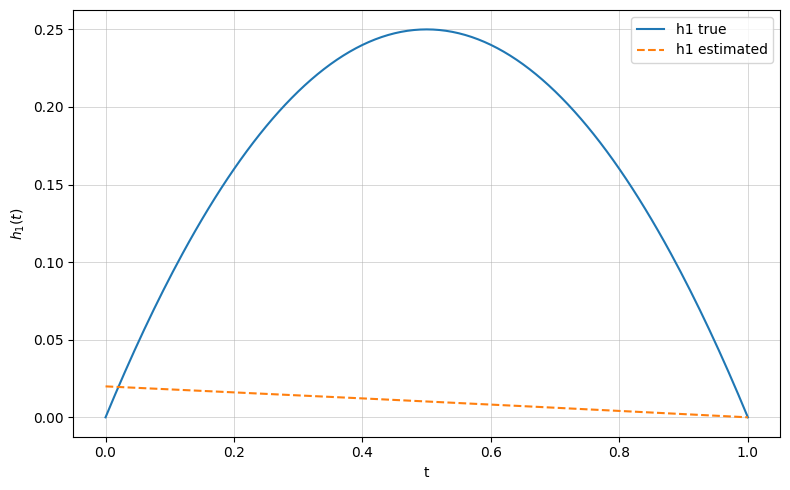

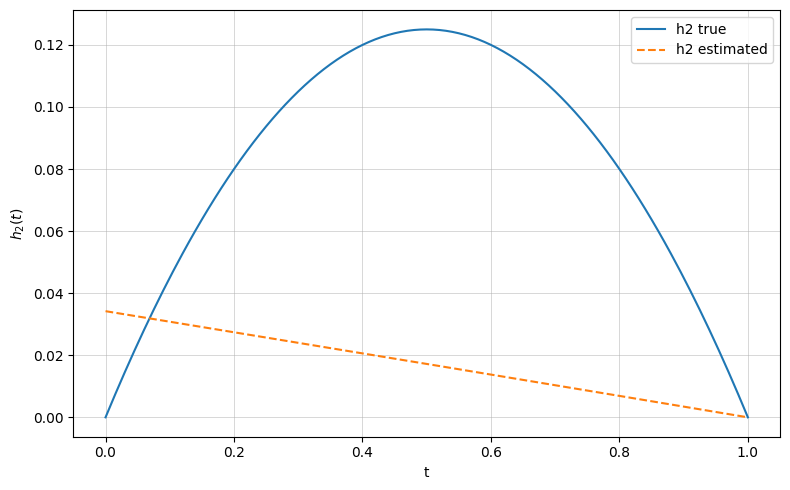

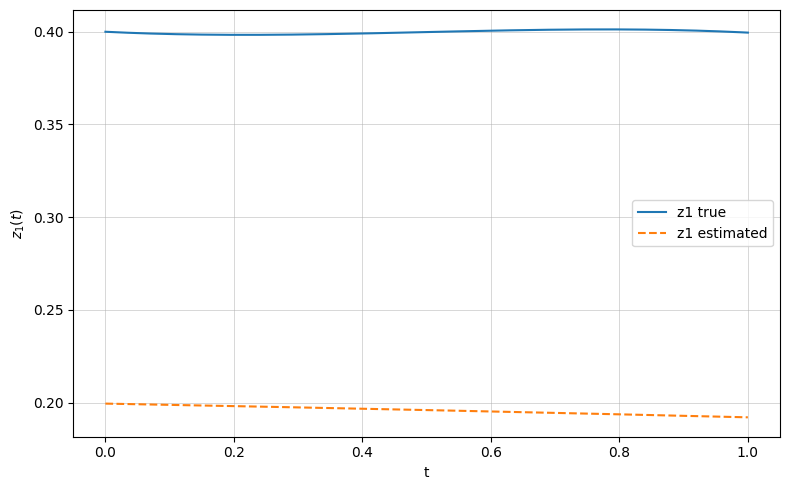

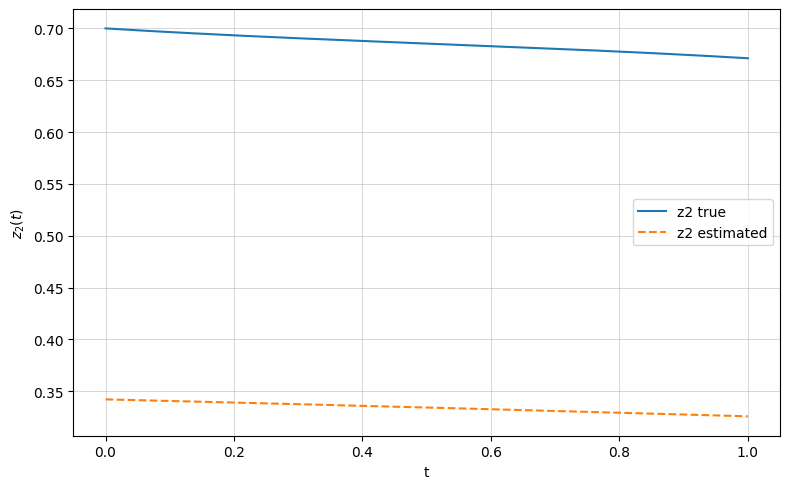

In [7]:
# Step 5: quick plots
make_plots(h_true, z_true, z_est, h_est, t, q1, q2, save=False, outdir = "figs")

In [8]:
# Step 5: metrics
z0_error, z0_energy, z_rmse, h_rmse, misfit, henergy = compute_metrics(C, z0, h_true, z_true, y_m, z0_est, z_est, h_est, t)
print("===== Résultats =====")
print(f"z0 true = {z0}, z0 estimated = {z0_est}, error = {z0_error}")
print(f"RMSE_z    = {z_rmse}")
print(f"RMSE_h    = {h_rmse}")
print(f"YMisfit   = {misfit}")
print(f"z0HEnergy = {z0_energy**2 + henergy}")
print(f"z0Energy  = {z0_energy}")
print(f"HEnergy   = {henergy}")

===== Résultats =====
z0 true = [0.4 0.7], z0 estimated = [0.19947936 0.34206653], error = 0.4102741707125233
RMSE(z)  = 0.2872698540328473
RMSE(h)  = 0.13373126799971846
Misfit   = 0.16504635040989868
HEnergy  = 0.0005279876183720686
z0Energy = 0.39598172545511384


## Sensibility of $q_2$

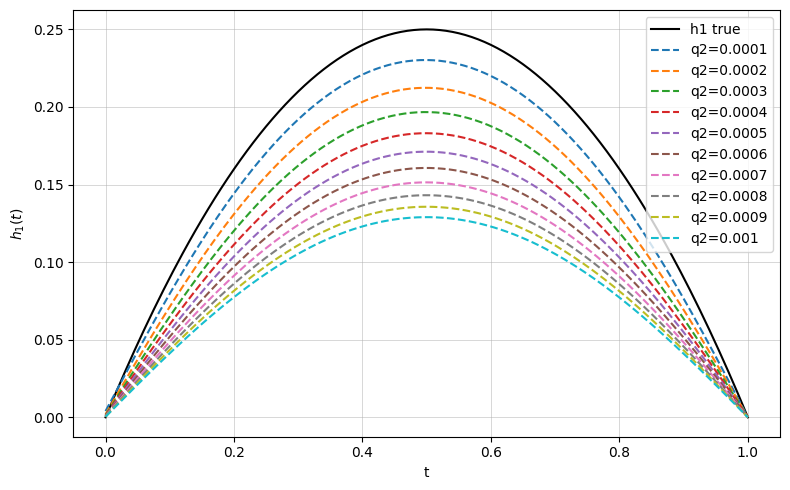

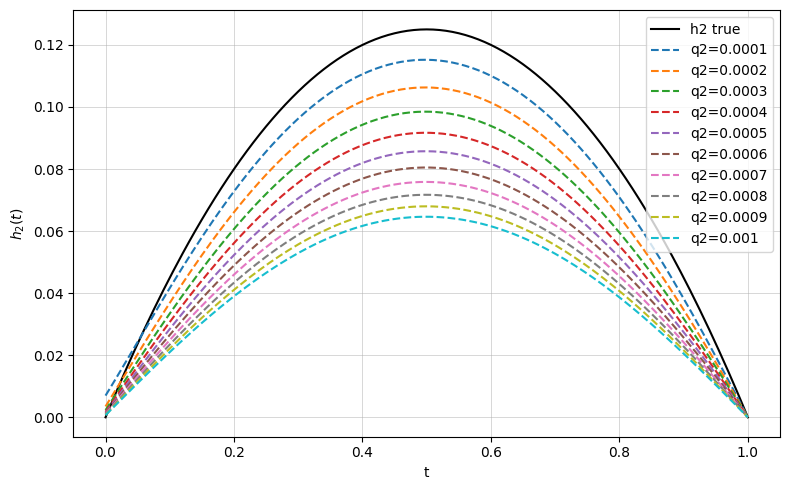

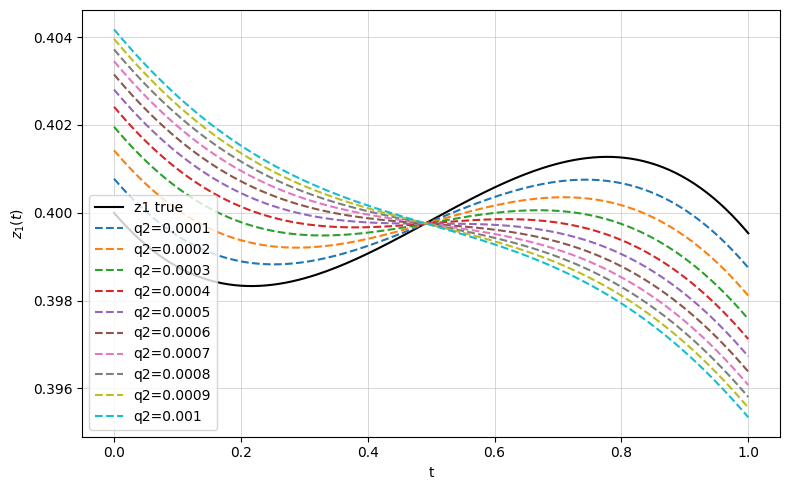

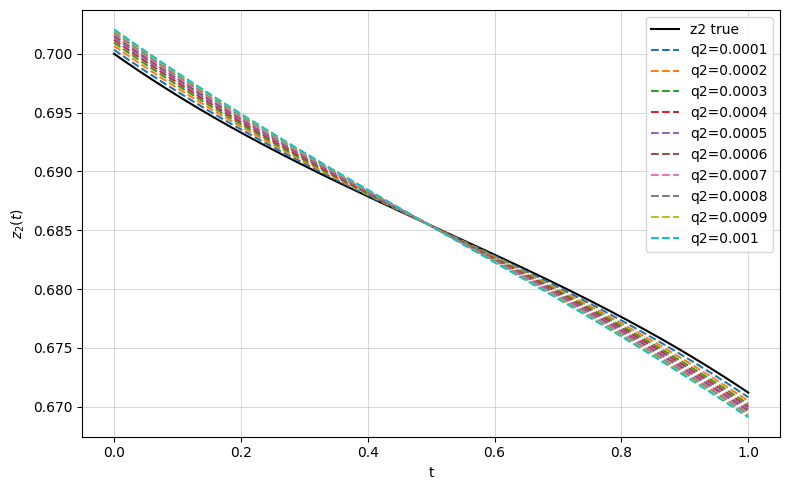

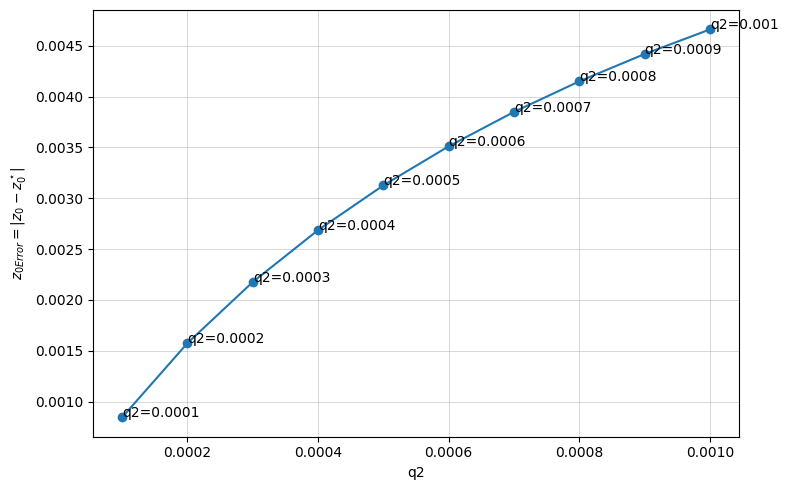

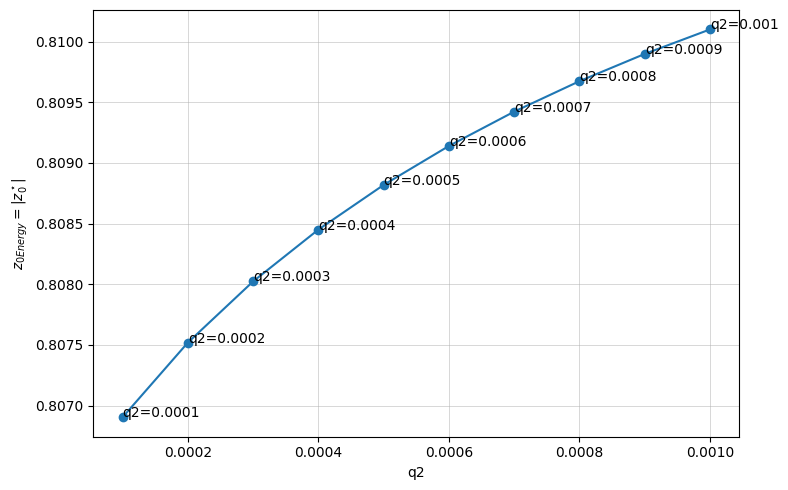

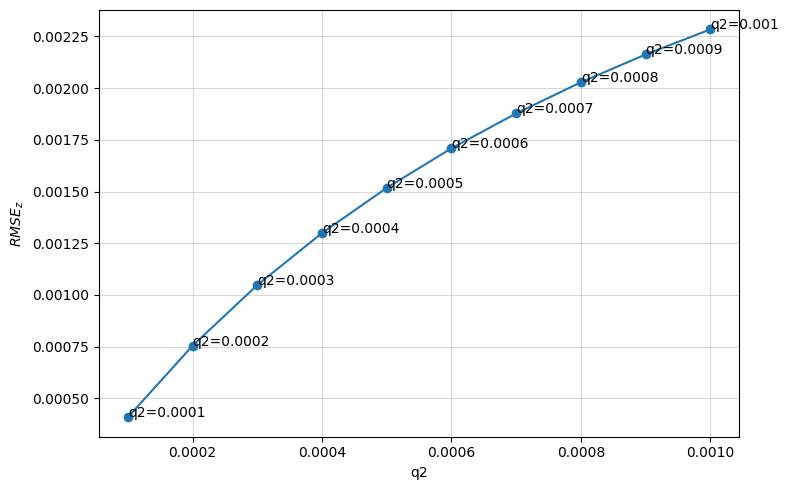

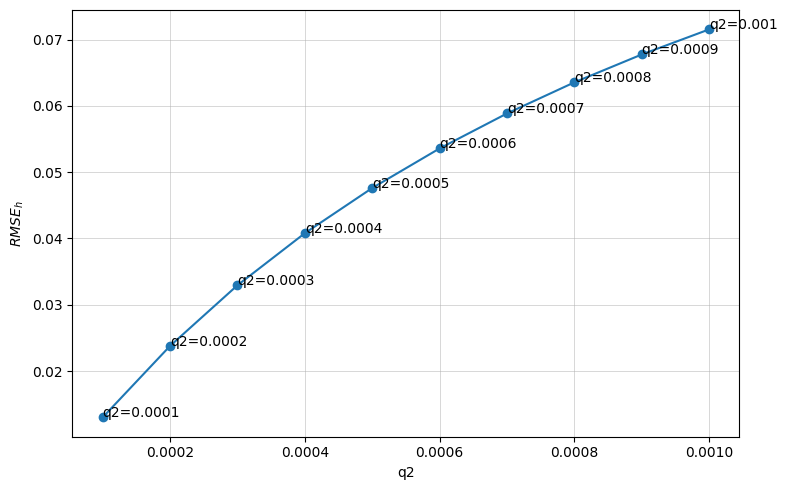

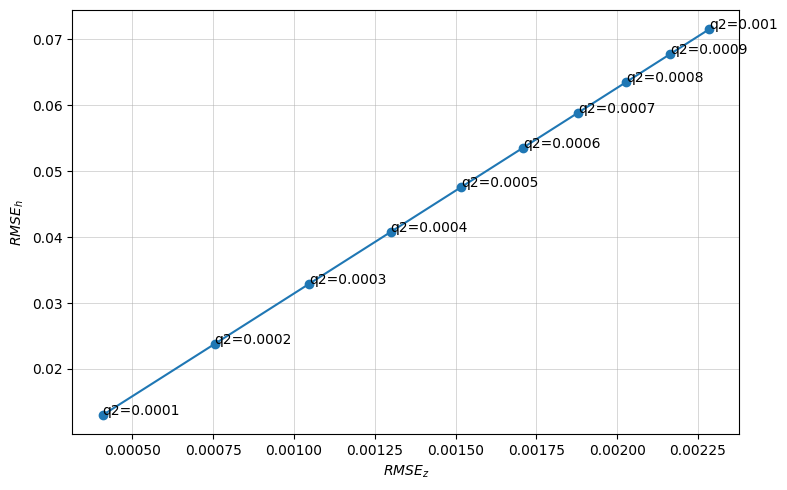

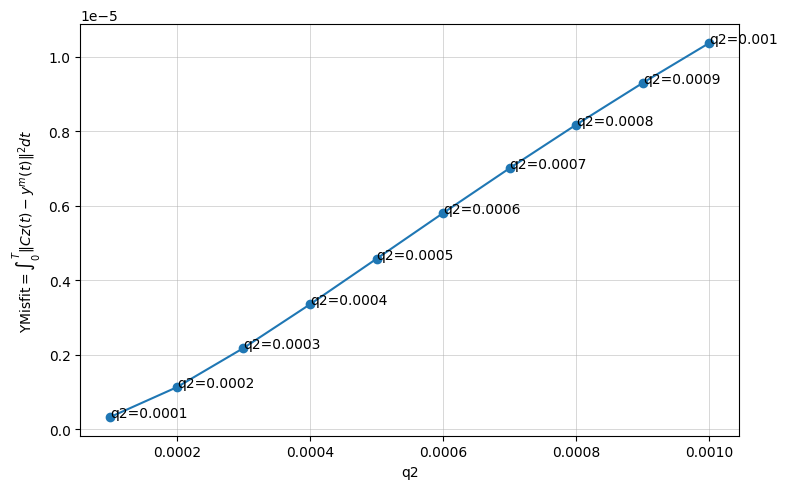

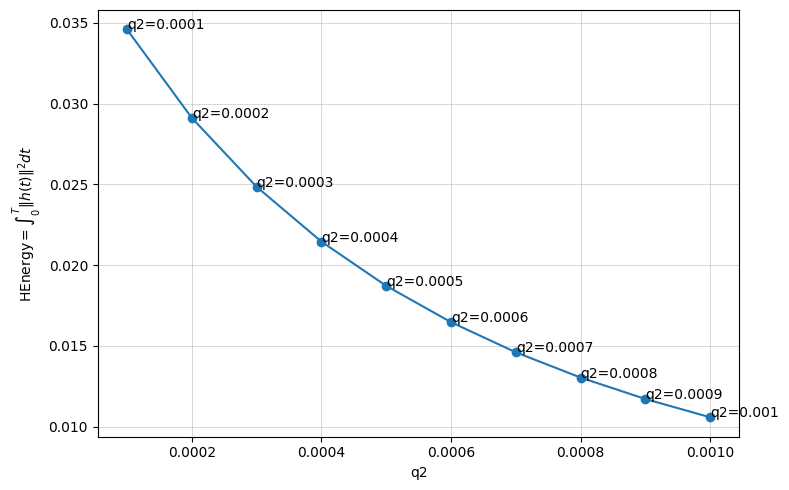

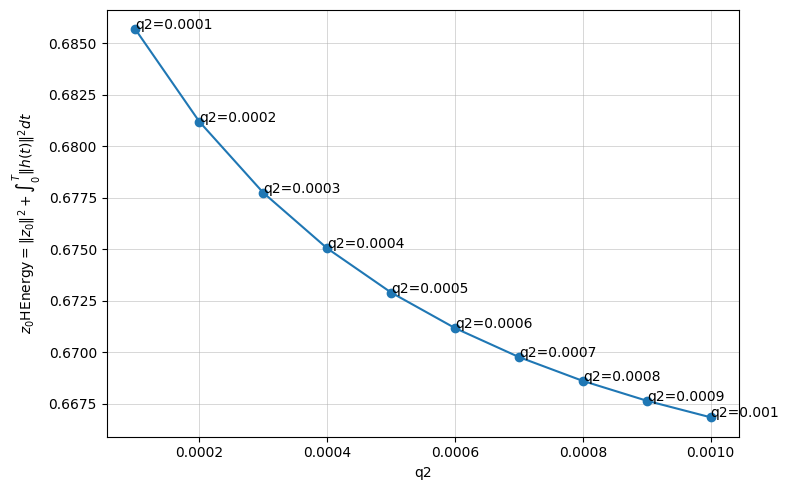

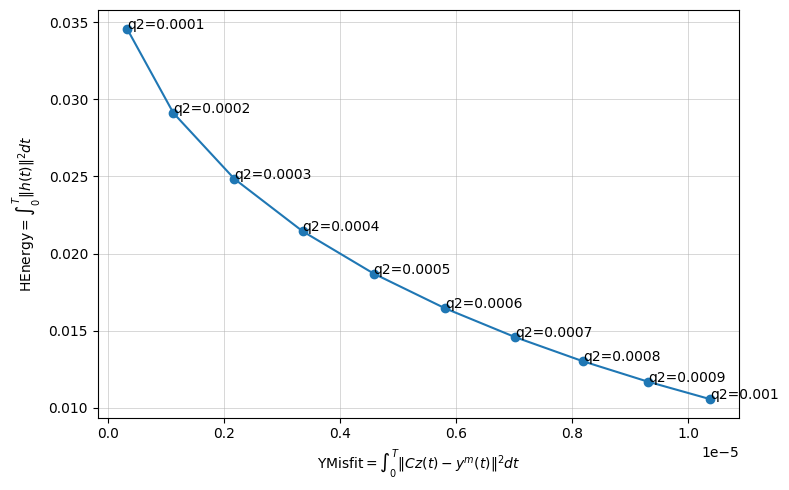

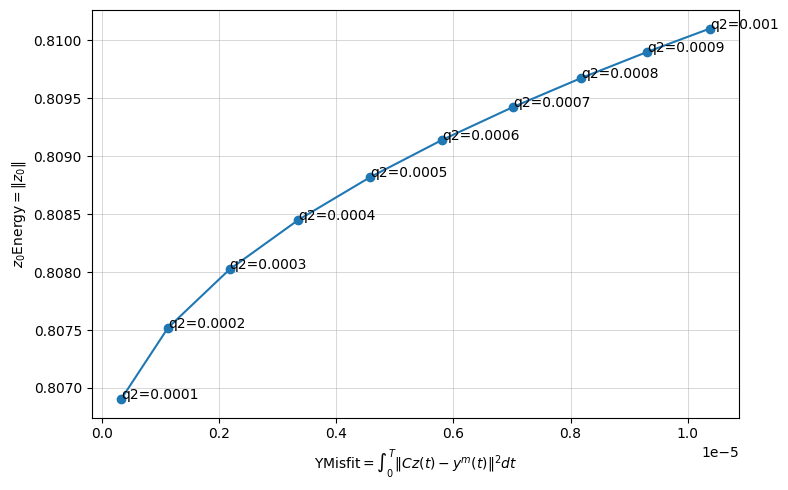

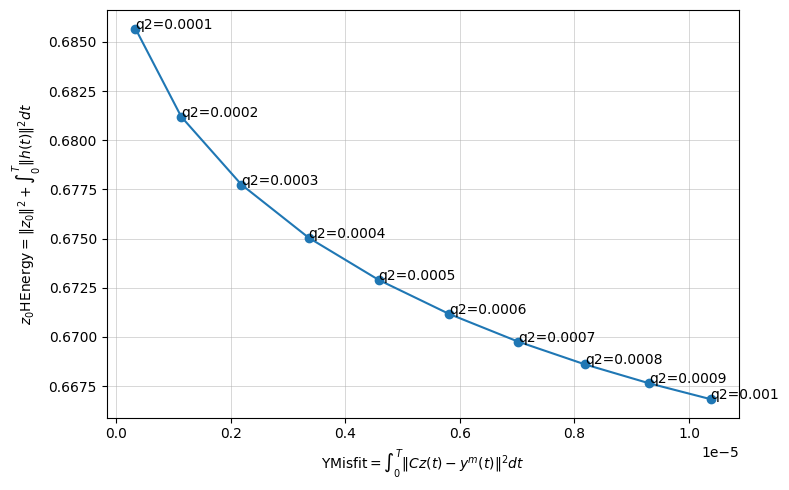

In [9]:
# Sensibility of q2: sweep q2, compute solutions & metrics
q1 = 1e-5
q2_list = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
q2_uniq_vals = q2_list.copy()   # needed for 3D plots

curves_z1, curves_z2, curves_h1, curves_h2, metrics = q2_sensibility(A, G2, C, z0, h1, h2, T, N, q1, q2_list, show=True, save=False, outdir = "figs")

The plots indicate to choice q2<0.0001. <br>
The elbow-based compromise on RMSE_z/RMSE_h indicate q2 arround 3e-5, while those on YMisfit/HEnergy indicate q2 arround 4e-5.. <br>
See the two results below.

In [10]:
print("Elbow-based compromise (L-curve on (RMSE_z, RMSE_h)):\nIn progress...")
q1 = 1e-5
q2_list = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009,  0.0001]    # refined and zoomed
q2_uniq_vals += q2_list     # needed for 3D plots
curves_z1, curves_z2, curves_h1, curves_h2, metrics = q2_sensibility(A, G2, C, z0, h1, h2, T, N, q1, q2_list, show=False, save=False, outdir = "figs")
idx_elbow_rmse = find_Lcurve_elbow(metrics, x_col="z_rmse", y_col="h_rmse", use_log=True, sort_on='q2')
row_star_rmse = metrics.loc[idx_elbow_rmse]
row_star_rmse

Elbow-based compromise (L-curve on (RMSE_z, RMSE_h)):
In progress...


q2           3.000000e-05
z0_error     2.048655e-04
z0_energy    8.063368e-01
z_rmse       1.269139e-04
h_rmse       5.205525e-03
misfit       3.206479e-08
henergy      3.942184e-02
energy       6.896009e-01
Name: 2, dtype: float64

In [11]:
print("Elbow-based compromise (L-curve on (YMisfit, Energy)):\nIn progress...")
q1 = 1e-5
q2_list = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009,  0.0001]    # refined and zoomed
q2_uniq_vals += q2_list     # needed for 3D plots
curves_z1, curves_z2, curves_h1, curves_h2, metrics = q2_sensibility(A, G2, C, z0, h1, h2, T, N, q1, q2_list, show=False, save=False, outdir = "figs")
idx_elbow_misfit = find_Lcurve_elbow(metrics, x_col="misfit", y_col="energy", use_log=True, sort_on='q2')
row_star_misfit = metrics.loc[idx_elbow_misfit]
row_star_misfit

Elbow-based compromise (L-curve on (YMisfit, Energy)):
In progress...


q2           4.000000e-05
z0_error     3.057961e-04
z0_energy    8.064341e-01
z_rmse       1.692882e-04
h_rmse       6.003737e-03
misfit       5.701347e-08
henergy      3.866636e-02
energy       6.890024e-01
Name: 3, dtype: float64

## Sensibility of $q_1$

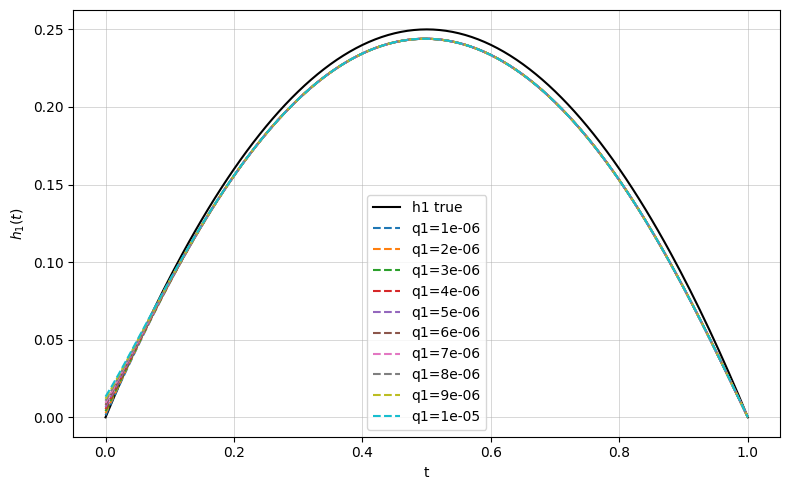

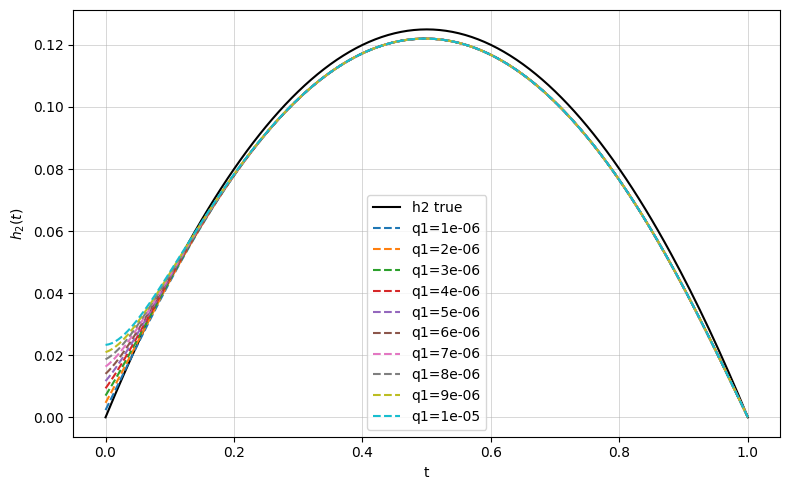

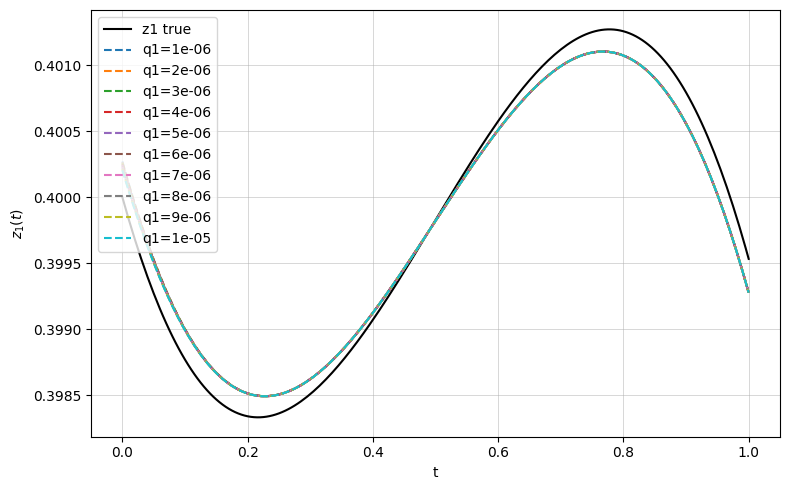

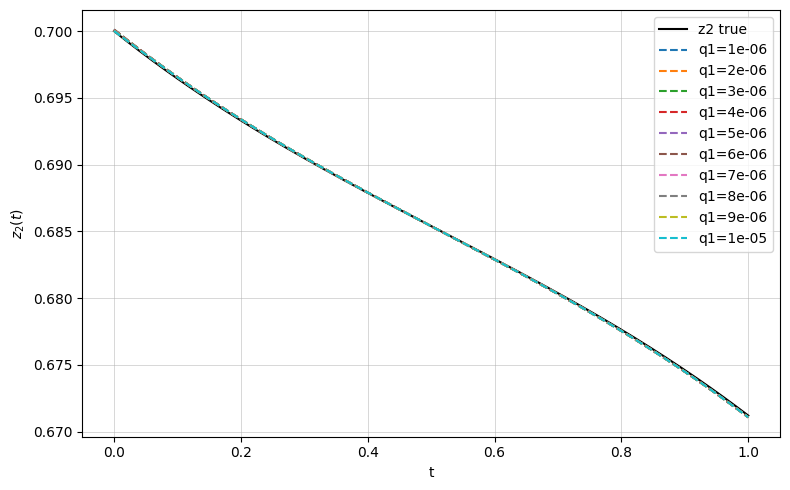

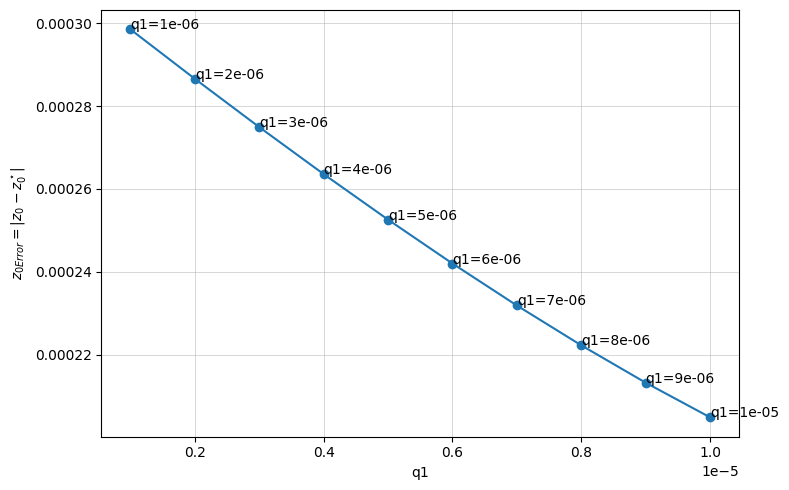

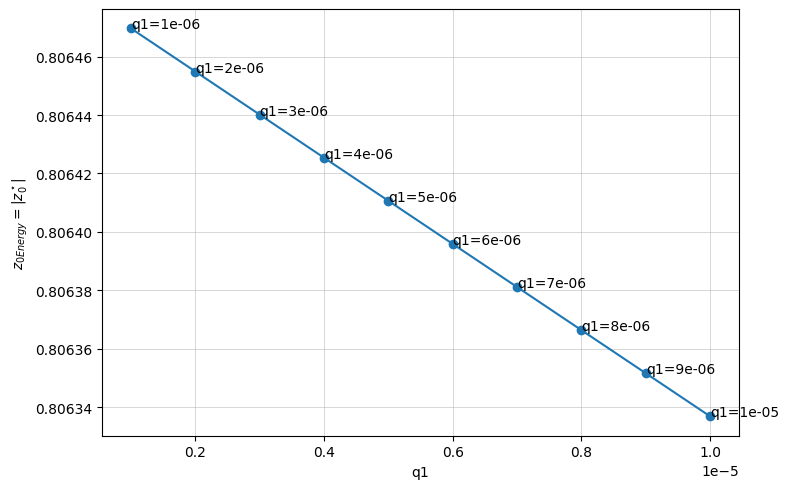

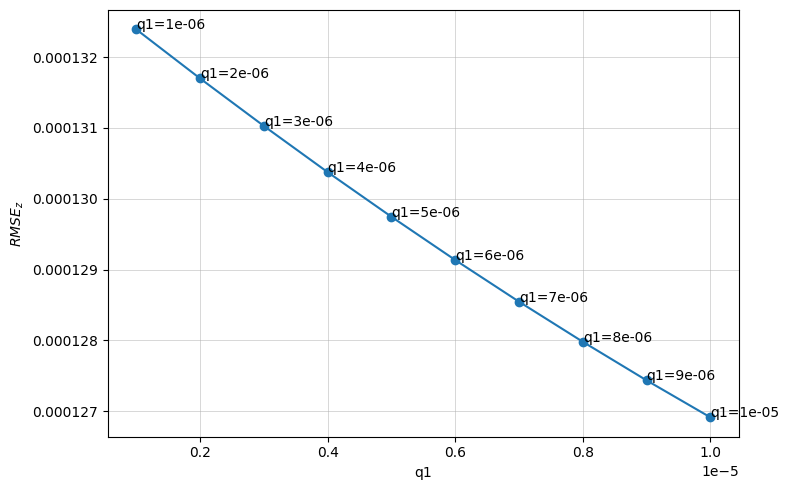

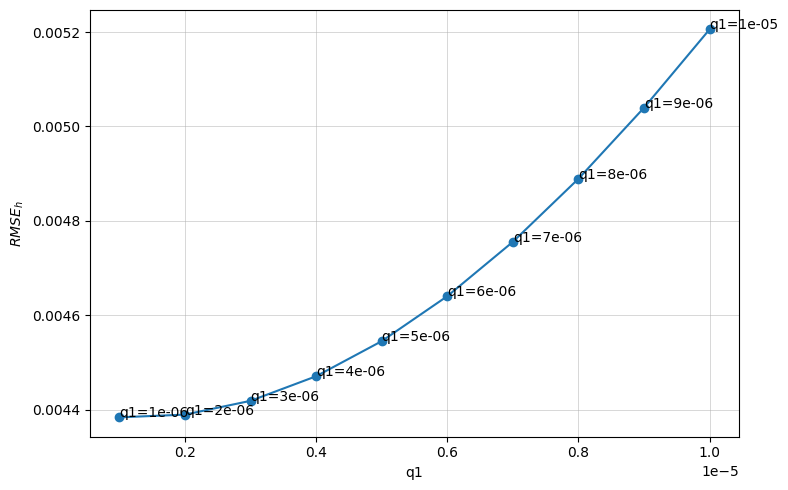

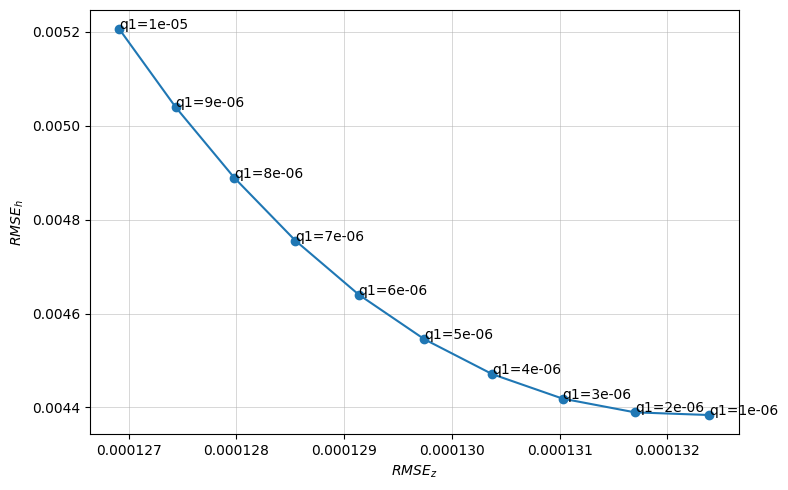

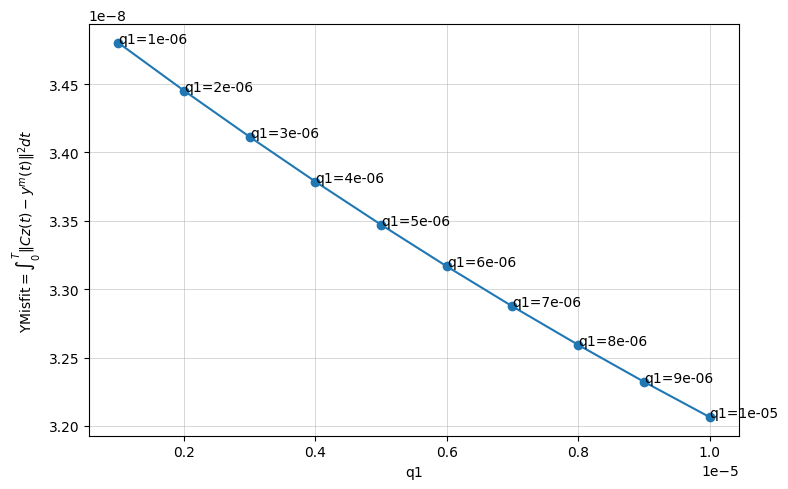

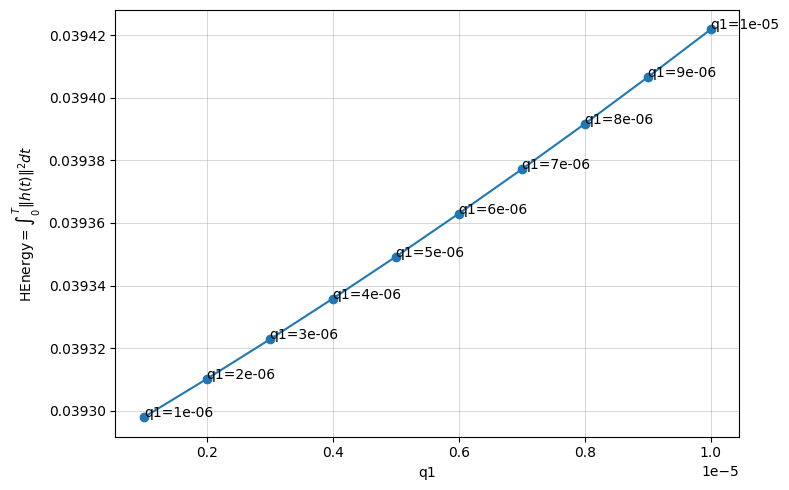

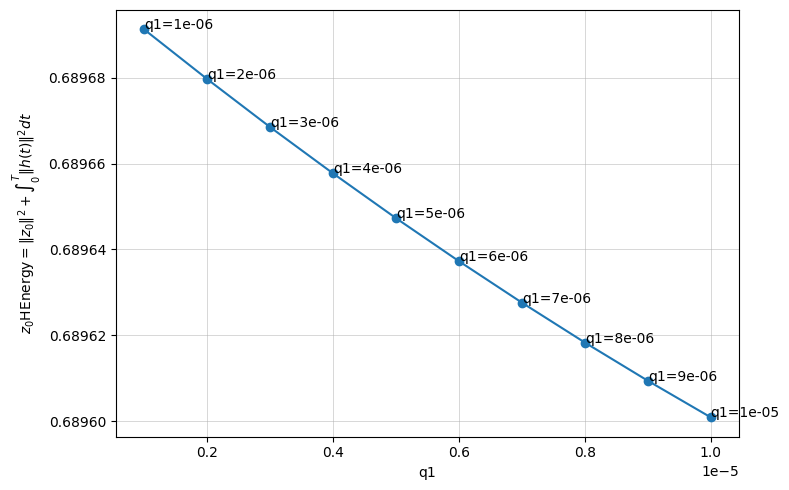

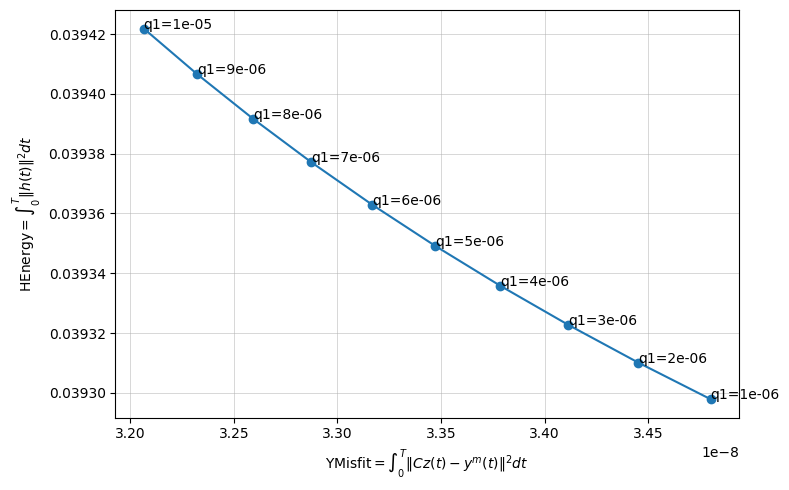

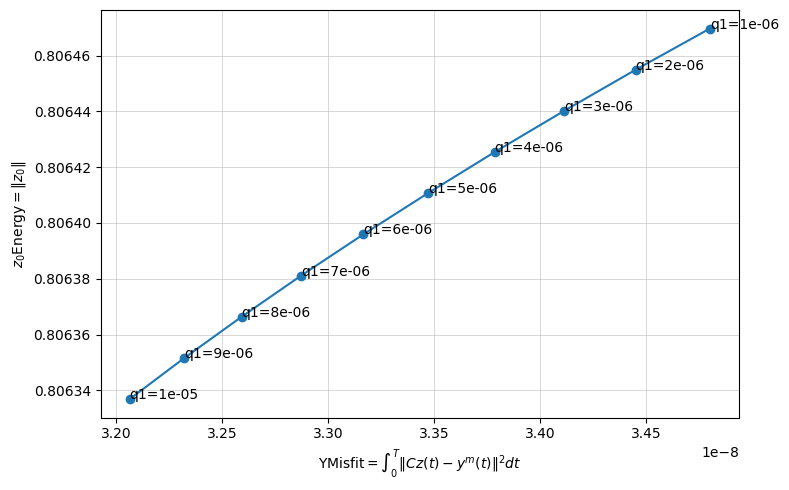

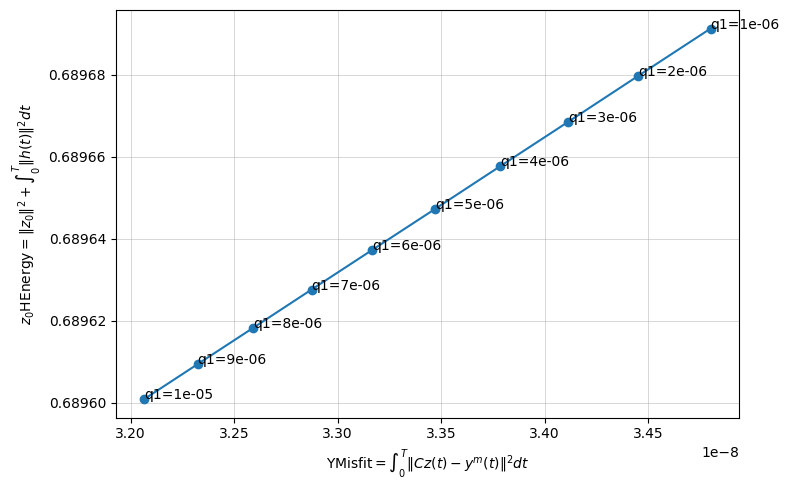

In [12]:
# Sensibility of q1: sweep q1, compute solutions & metrics
# q1_list = [1e-10, 5e-10, 1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
q1_list = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5]
q1_uniq_vals = q1_list.copy()     # needed for 3D plots
q2 = 3e-5     # choice from L-curve on (RMSE_z, RMSE_h)

curves_z1, curves_z2, curves_h1, curves_h2, metrics = q1_sensibility(A, G2, C, z0, h1, h2, T, N, q1_list, q2, show=True, save=False, outdir = "figs")

The plots indicate to choice q1 arround 5e-6. <br>
The elbow-based compromise on RMSE_z/RMSE_h indicate q1=5e-6<br>
See the result below.

In [13]:
print("Elbow-based compromise (L-curve on (RMSE_z, RMSE_h)):\nIn progress...")
# q1_list = [1e-10, 5e-10, 1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
q1_list = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5]
q1_uniq_vals += q1_list     # needed for 3D plots
q2 = 3e-5  # choice from L-curve on (RMSE_z, RMSE_h)

curves_z1, curves_z2, curves_h1, curves_h2, metrics = q1_sensibility(A, G2, C, z0, h1, h2, T, N, q1_list, q2, show=False, save=False, outdir = "figs")
idx_elbow_rmse = find_Lcurve_elbow(metrics, x_col="z_rmse", y_col="h_rmse", use_log=True, sort_on='q1')
row_star_rmse = metrics.loc[idx_elbow_rmse]
row_star_rmse

Elbow-based compromise (L-curve on (RMSE_z, RMSE_h)):
In progress...


q1           5.000000e-06
z0_error     2.525956e-04
z0_energy    8.064106e-01
z_rmse       1.297460e-04
h_rmse       4.545017e-03
misfit       3.347123e-08
henergy      3.934920e-02
energy       6.896473e-01
Name: 4, dtype: float64

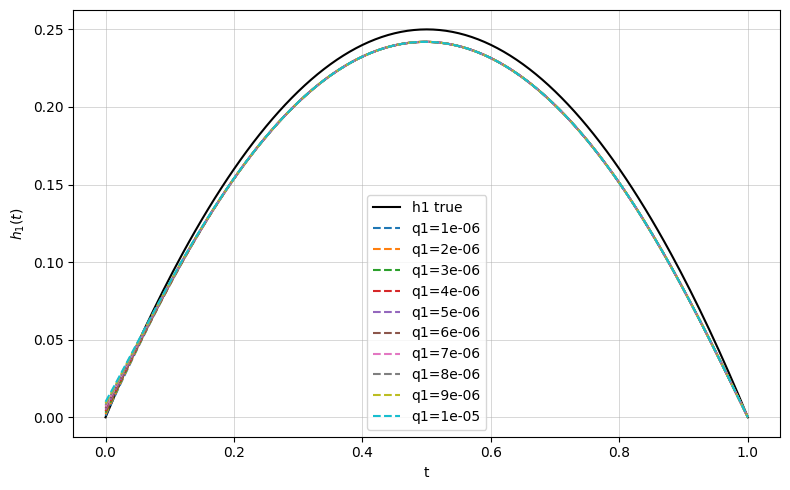

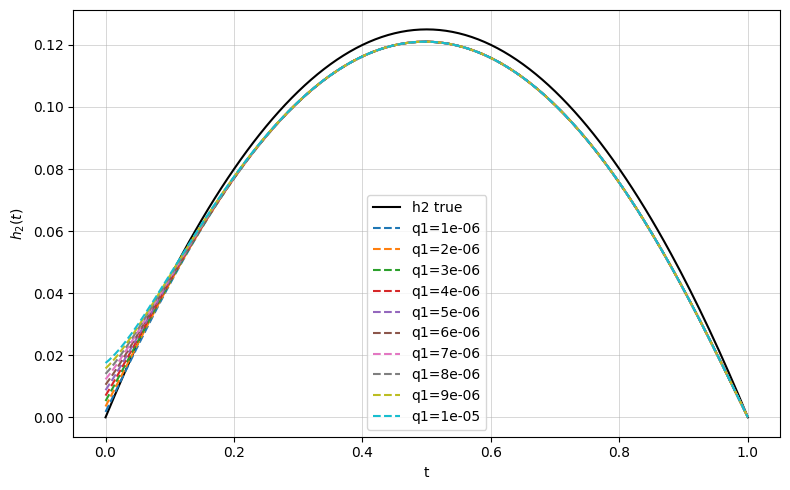

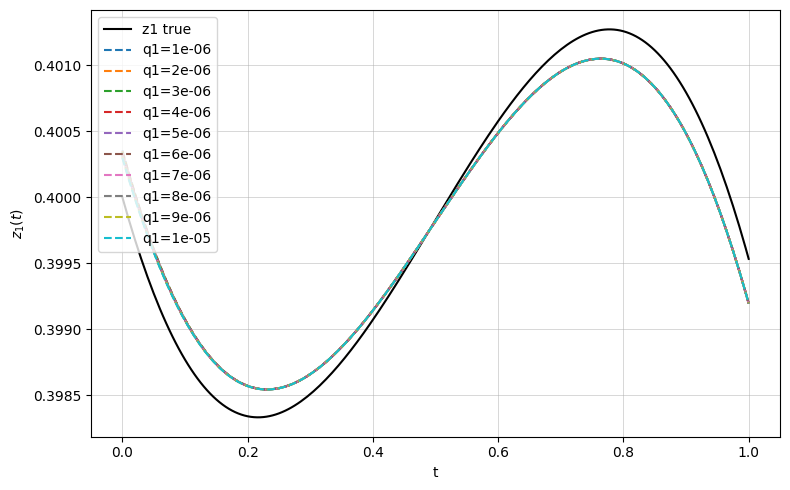

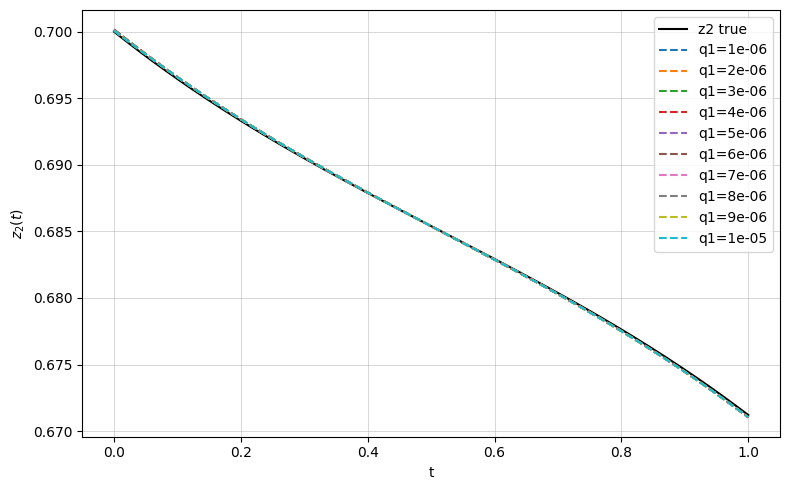

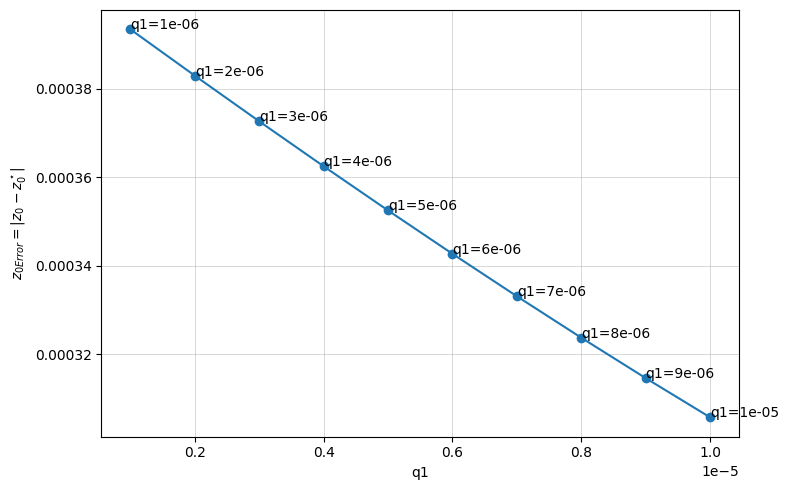

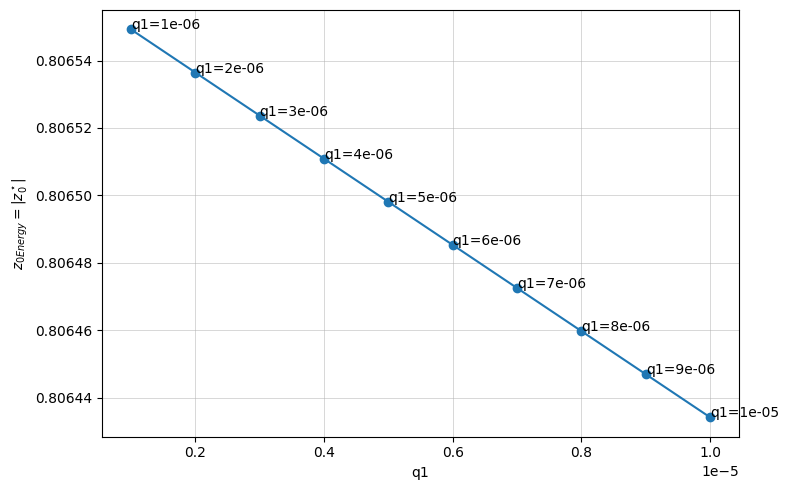

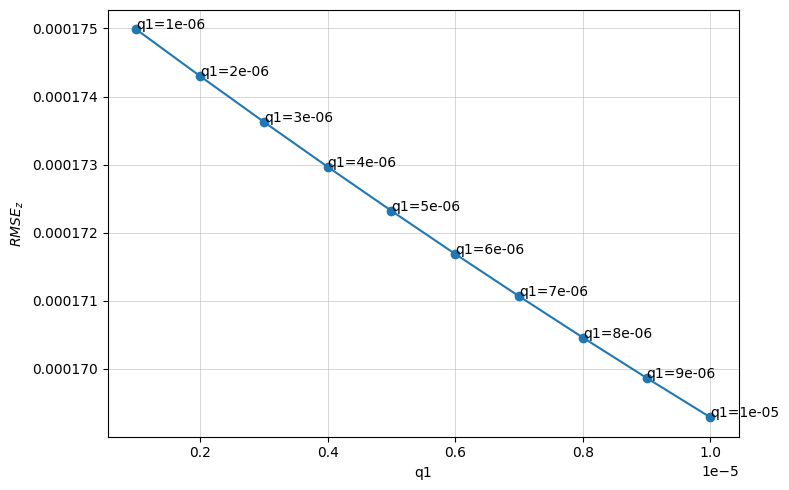

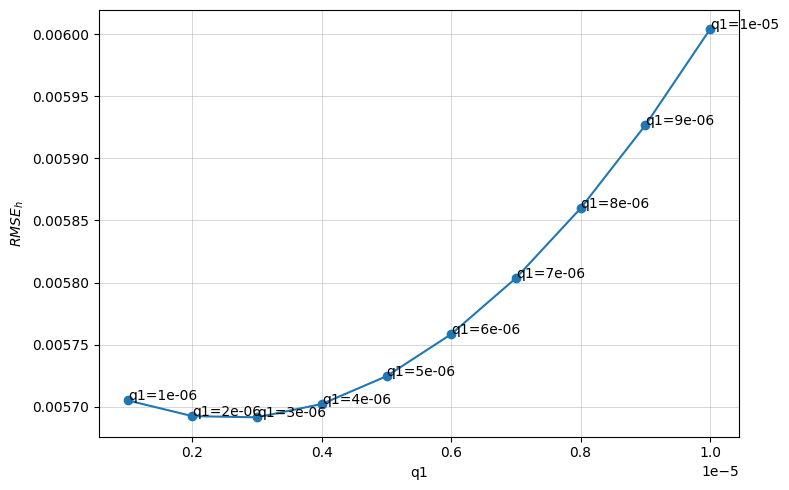

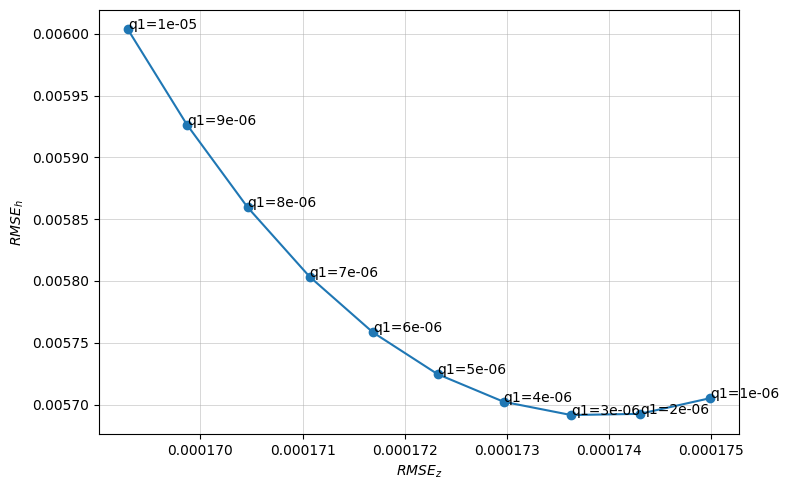

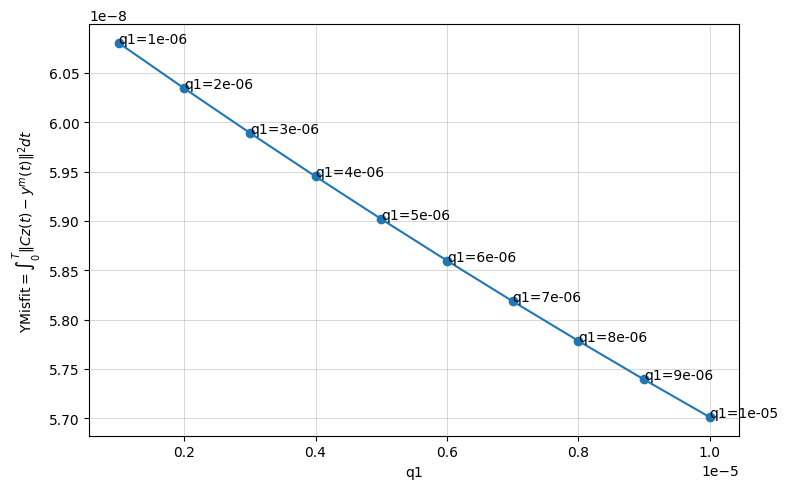

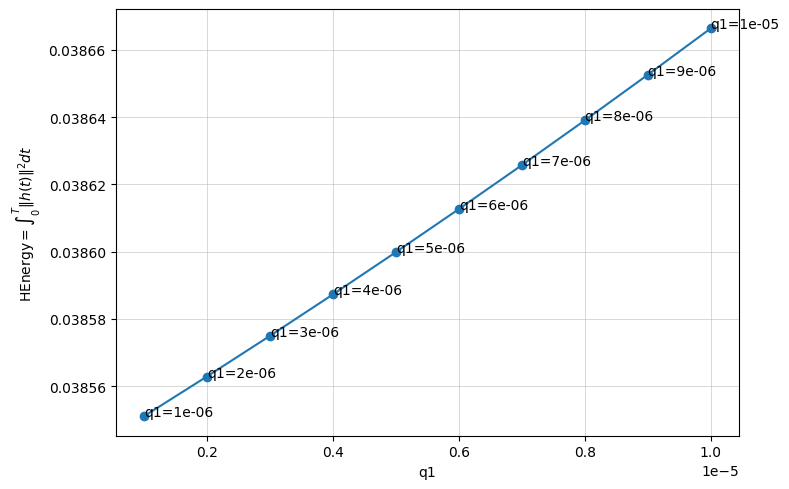

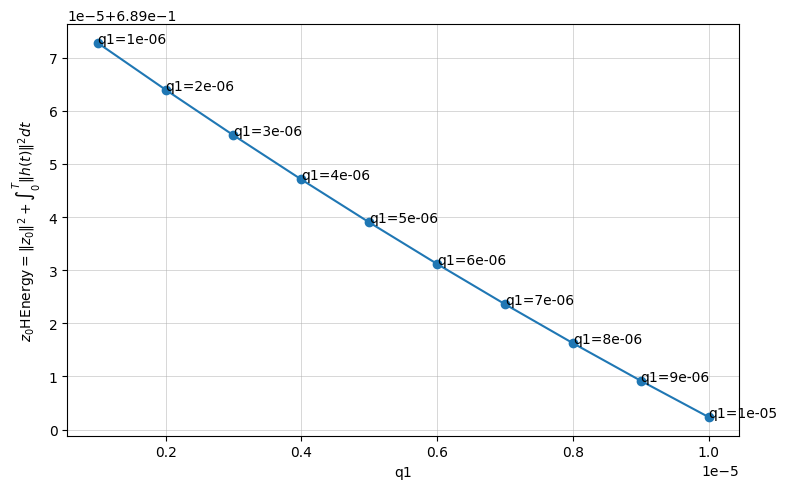

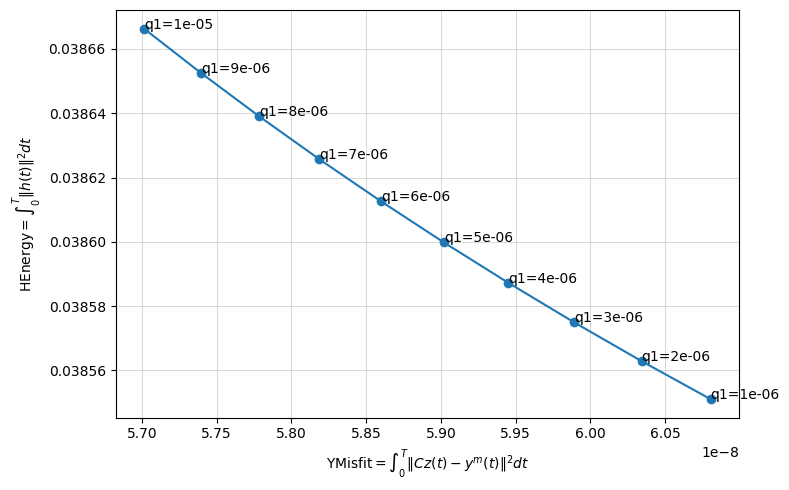

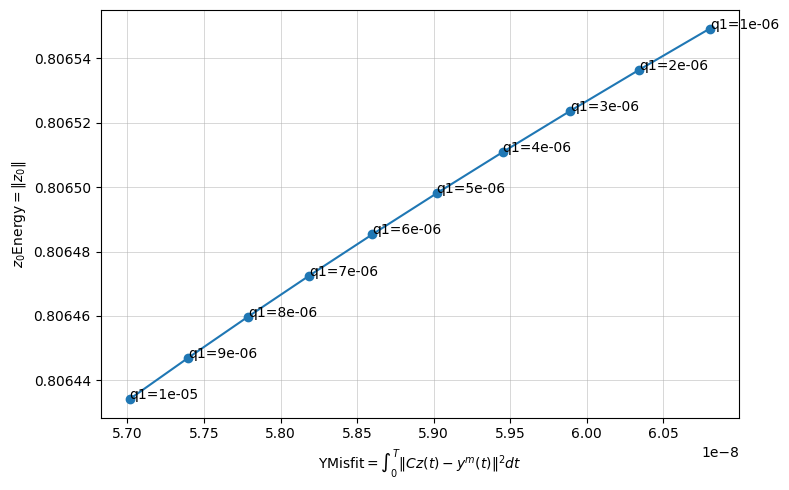

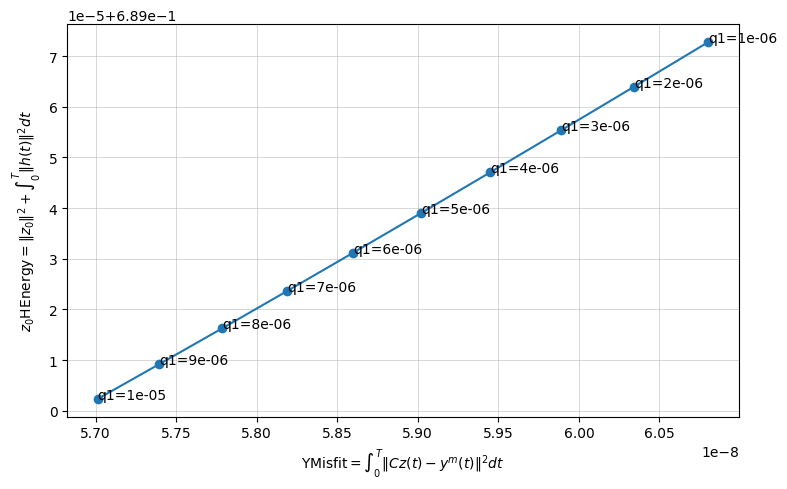

In [14]:
# 2nd sensibility of q1: sweep q1, compute solutions & metrics
# q1_list = [1e-10, 5e-10, 1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
q1_list = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5]
q1_uniq_vals += q1_list     # needed for 3D plots
q2 = 4e-5  # choice from L-curve on (YMisfit, z0HEnergy)

curves_z1, curves_z2, curves_h1, curves_h2, metrics = q1_sensibility(A, G2, C, z0, h1, h2, T, N, q1_list, q2, show=True, save=False, outdir = "figs")

Also here, the plots indicate to choice q1 arround 5e-6. <br>
The elbow-based compromise on YMisfit/HEnergy indicate q1=5e-6. <br>
See the two results below.

In [15]:
print("Elbow-based compromise (L-curve on (YMisfit, Energy)):\nIn progress...")
# q1_list = [1e-10, 5e-10, 1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
q1_list = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5]
q1_uniq_vals += q1_list     # needed for 3D plots
q2 = 4e-5  # choice from L-curve on (YMisfit, z0HEnergy)

curves_z1, curves_z2, curves_h1, curves_h2, metrics = q1_sensibility(A, G2, C, z0, h1, h2, T, N, q1_list, q2, show=False, save=False, outdir = "figs")
idx_elbow_misfit = find_Lcurve_elbow(metrics, x_col="misfit", y_col="energy", use_log=True, sort_on='q1')
row_star_misfit = metrics.loc[idx_elbow_misfit]
row_star_misfit

Elbow-based compromise (L-curve on (YMisfit, Energy)):
In progress...


q1           5.000000e-06
z0_error     3.524880e-04
z0_energy    8.064981e-01
z_rmse       1.723216e-04
h_rmse       5.724563e-03
misfit       5.901947e-08
henergy      3.859984e-02
energy       6.890390e-01
Name: 4, dtype: float64

## Sensibility of $q_1$ and $q_2$

In [16]:
q1_vals = list(np.unique(q1_uniq_vals))
q2_vals = list(np.unique(q2_uniq_vals))
print(q1_vals)
print(q2_vals)

[1e-06, 2e-06, 3e-06, 4e-06, 5e-06, 6e-06, 7e-06, 8e-06, 9e-06, 1e-05]
[1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]


Elbow-based compromise (L-curve on (RMSE_z, RMSE_h)
  q1* = 1e-05, q2* = 1e-05
  z0Error*     = 0.00017322682302418966
  RMSE_z*      = 4.7125821331296974e-05
  RMSE_h*      = 0.00826870734086433
  YMisfit*     = 4.3127306750436686e-09
  z0HEnergy*   = 0.6907682475921272
  z0Energy*    = 0.806064151243763
  HEnergy*     = 0.04102883167179921
  J*           = 6.911995206596316e-06
---------------------------------------------------------------------- 
Plot process: ...


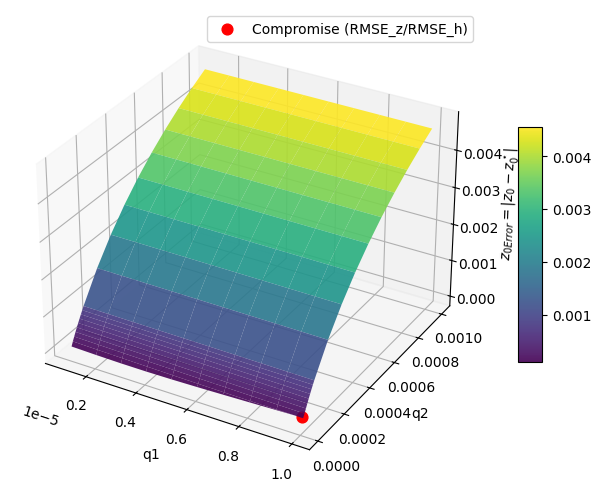

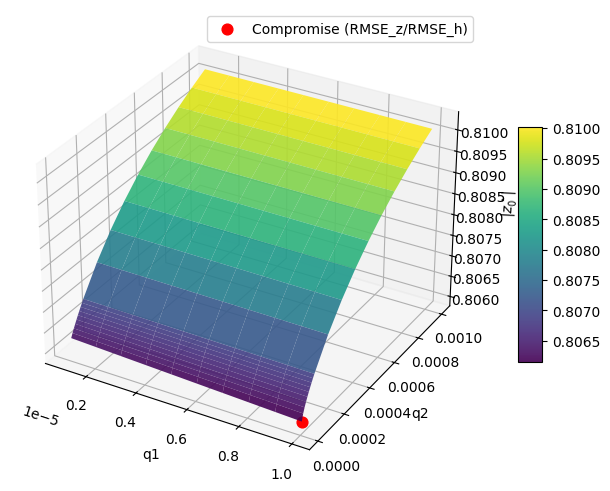

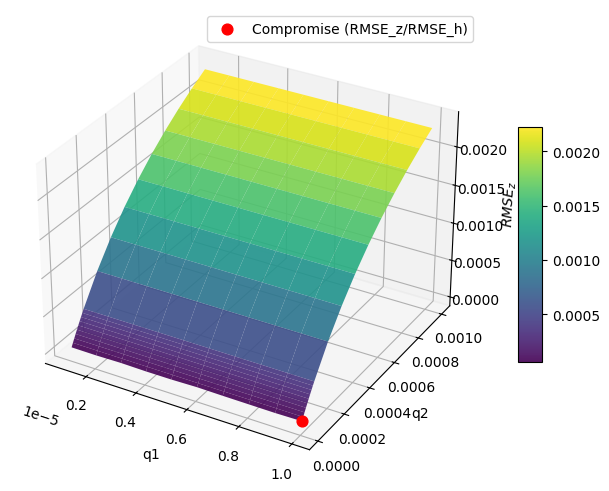

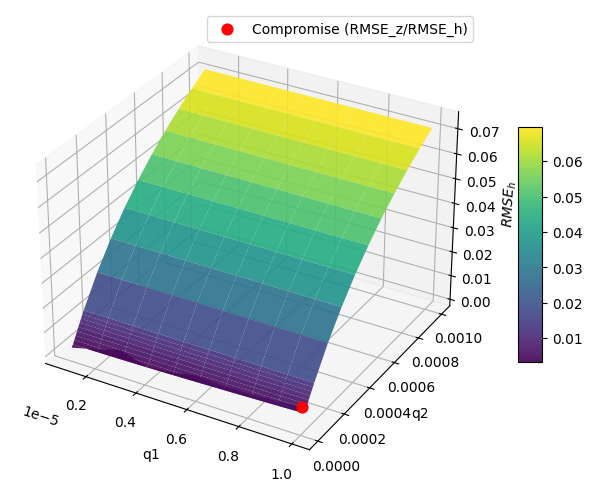

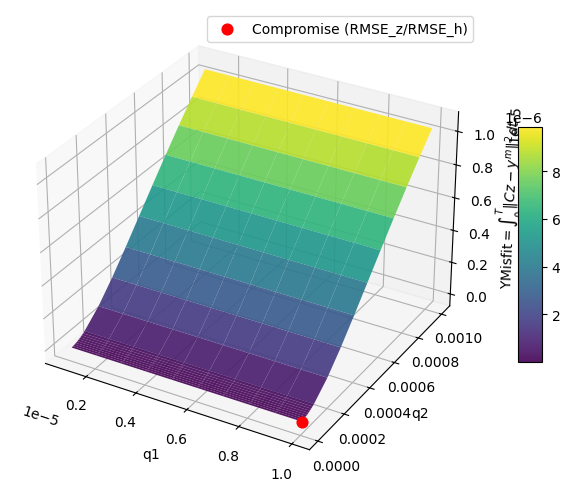

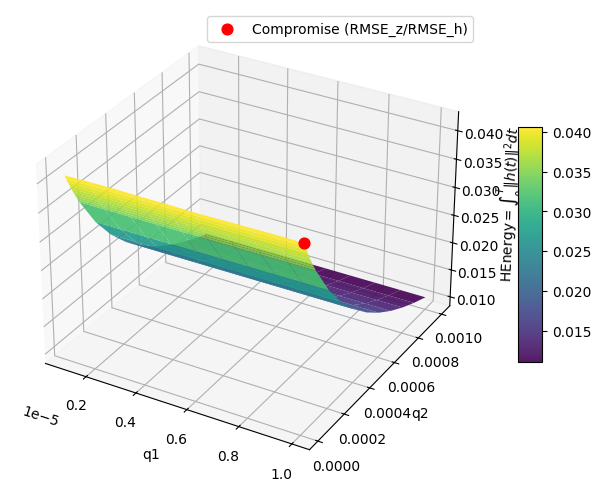

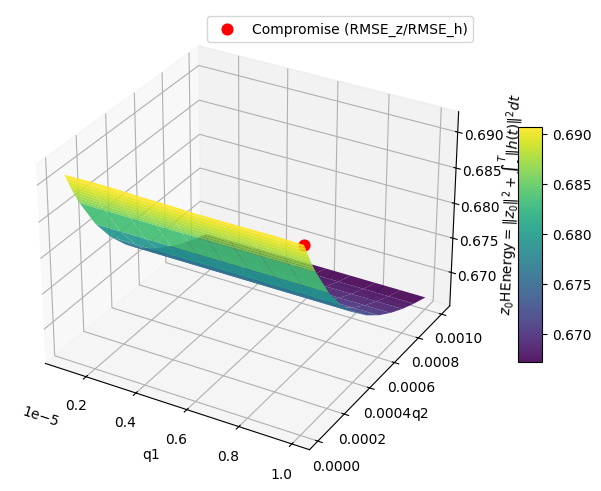

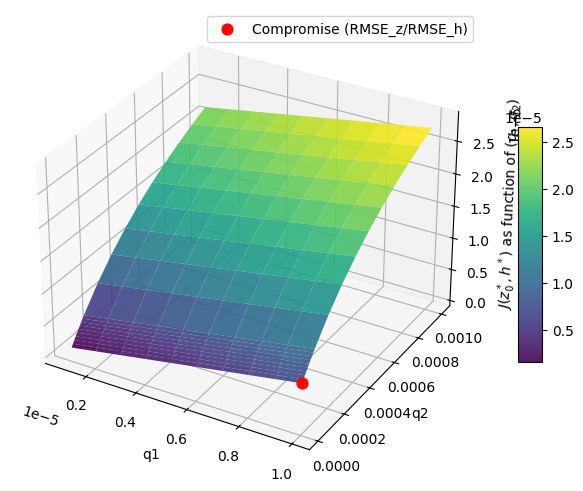

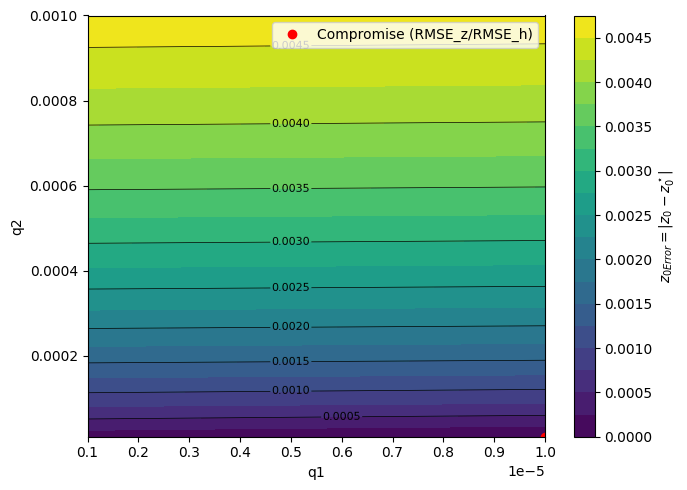

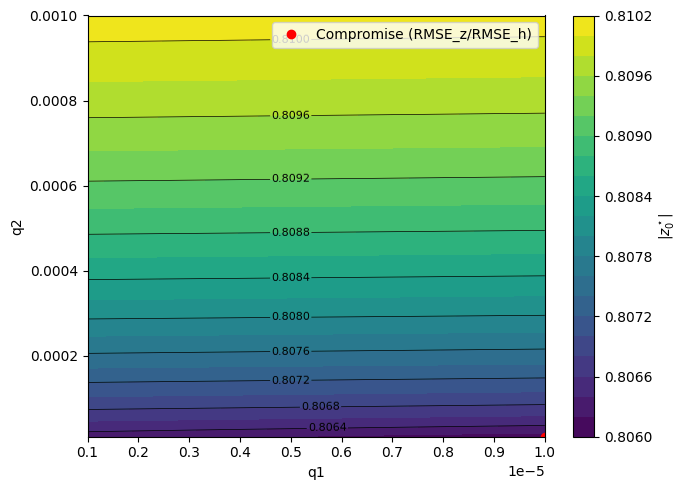

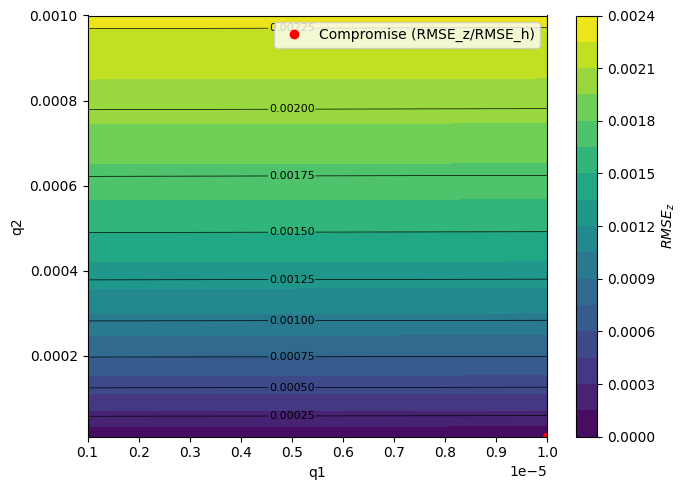

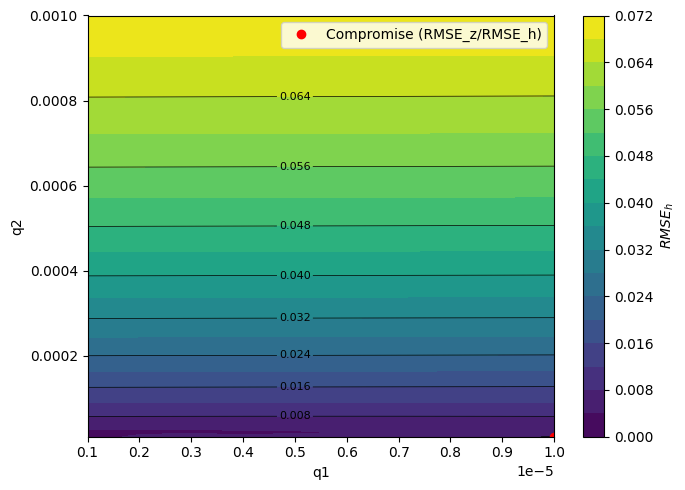

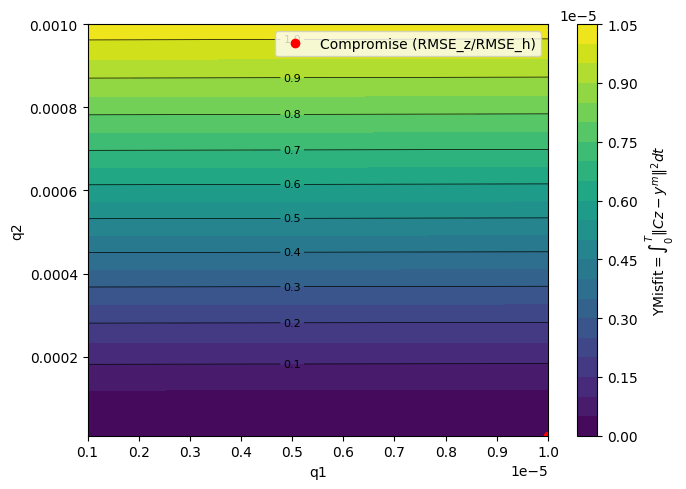

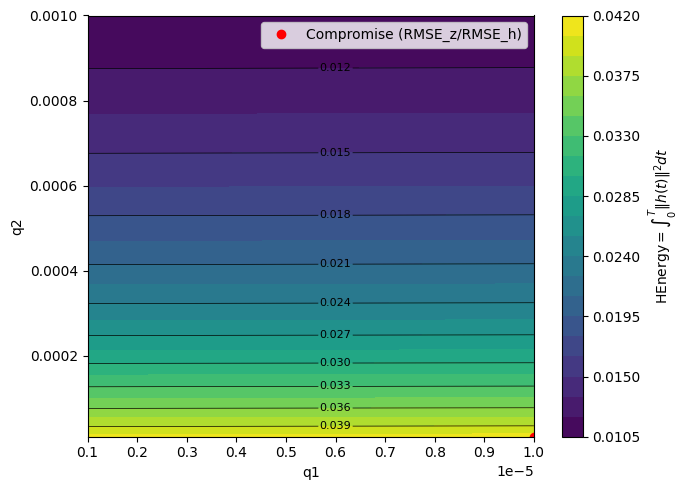

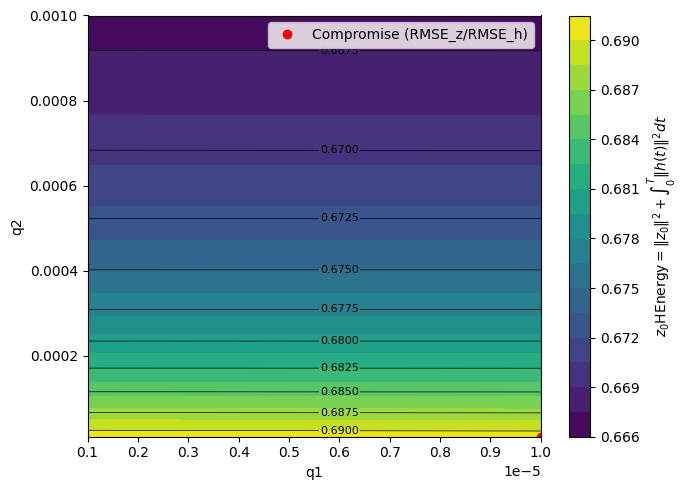

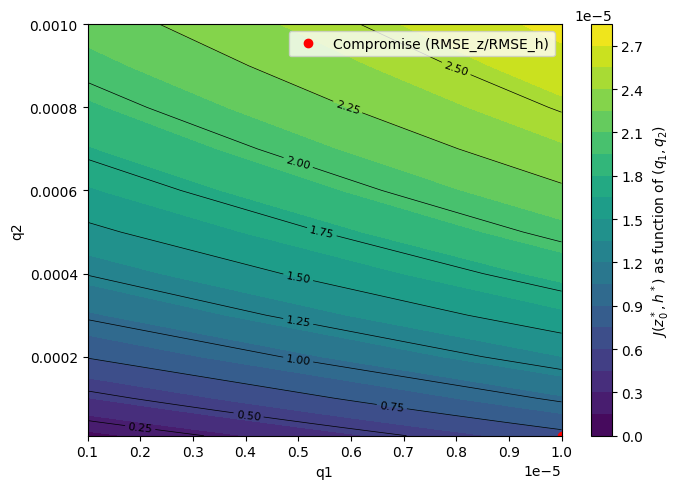

In [17]:
# Sensibility of q1 and q2: sweep q1 and q2, compute solutions & metrics, and search optimum q1 and q2 as L-curve compromise on RMSE_z/RMSE_h
# q1_vals = [0.001, 0.002, 0.005, 0.008, 0.01, 0.015, 0.02, 0.05, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]
# q2_vals = [0.25, 0.5, 1, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 7, 8, 8.25, 8.5, 8.75, 9, 9.25, 9.5, 9.75, 10, 10.25, 10.5, 10.75, 11, 20, 50, 100]

# q1_vals = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]
# q2_vals = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]

# q1_vals = np.linspace(0.001, 1, 10)
# q2_vals = np.linspace(0.001, 1, 10)

# q1_vals = [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5]
# q2_vals = [0.01, 0.1, 0.25, 0.5, 1, 2, 5]
curves_z, curves_h, metrics, q1_opt, q2_opt = q12_sensibility_with_optimum(A, G2, C, z0, h1, h2, T=1, N=200, 
                                                                           q1_list=q1_vals, q2_list=q2_vals, elbow_on='rmse', save=False, outdir="figs")

===== Results with q1*=1e-05 and q2*=1e-05 =====
z0 true = [0.4 0.7], z0 estimated = [0.39997393 0.69982875], error = 0.00017322682302418966
RMSE_z   = 4.7125821331296974e-05
RMSE_h   = 0.00826870734086433
YMisfit  = 4.3127306750436686e-09
HEnergy  = 0.04102883167179921
z0Energy = 0.806064151243763


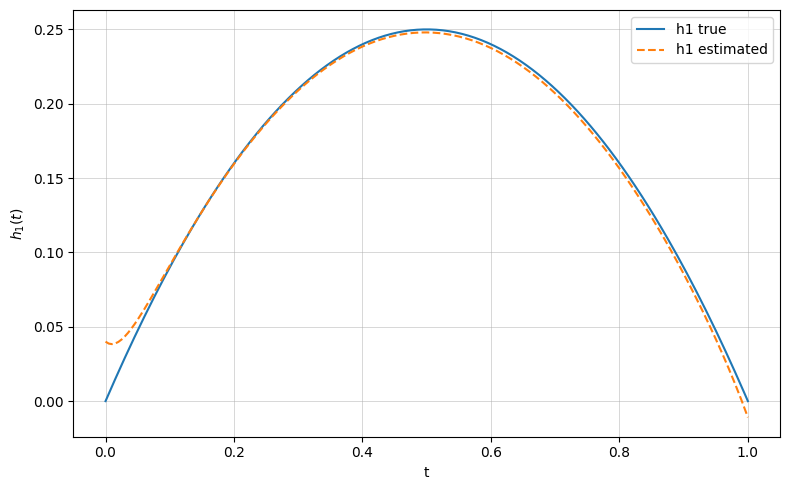

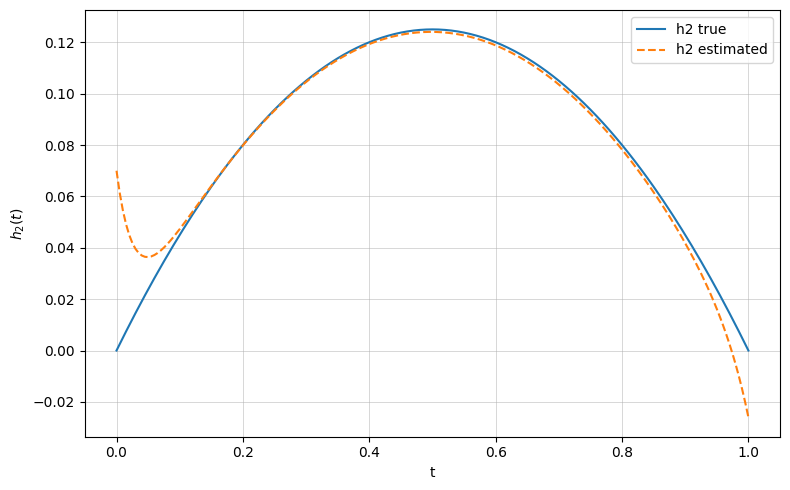

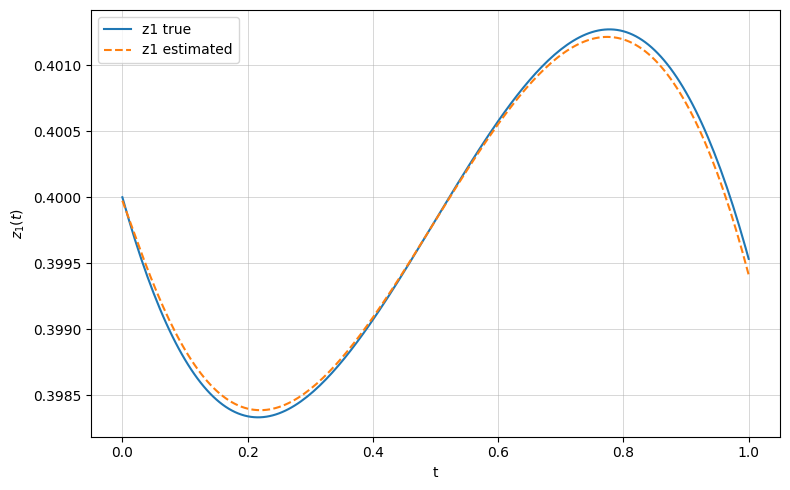

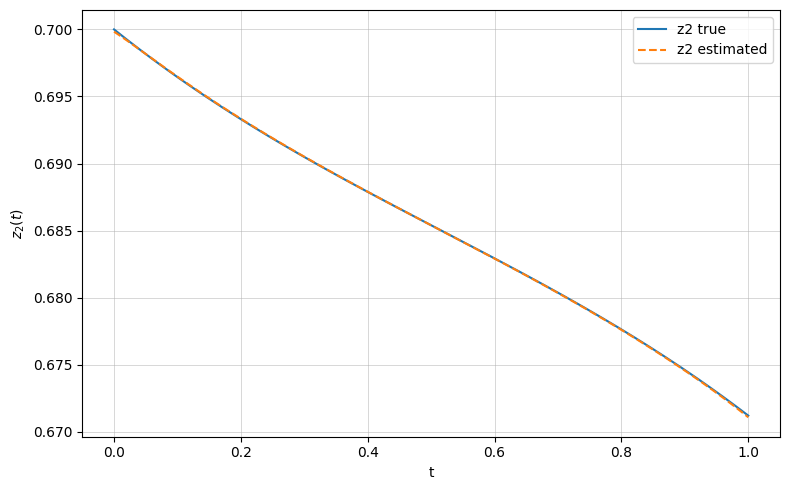

In [18]:
# Simulation for q1_opt and q2_opt (step 1 to 4)
h_true, z_true, y_m, z0_est, z_est, h_est = simulate_n2(A, G2, C, z0, h1, h2, T, N, q1_opt, q2_opt)

# Step 5: metrics
z0_error, z0_energy, z_rmse, h_rmse, misfit, henergy = compute_metrics(C, z0, h_true, z_true, y_m, z0_est, z_est, h_est, t)
print(f"===== Results with q1*={q1_opt} and q2*={q2_opt} =====")
print(f"z0 true = {z0}, z0 estimated = {z0_est}, error = {z0_error}")
print(f"RMSE_z    = {z_rmse}")
print(f"RMSE_h    = {h_rmse}")
print(f"YMisfit   = {misfit}")
print(f"z0HEnergy = {z0_energy**2 + henergy}")
print(f"z0Energy  = {z0_energy}")
print(f"HEnergy   = {henergy}")

# Step 5: quick plots
make_plots(h_true, z_true, z_est, h_est, t, q1_opt, q2_opt, save=False, outdir = "figs")

Elbow-based compromise (L-curve on (YMisfit, z0HEnergy)) :
  q1* = 1e-06, q2* = 0.0001
  z0Error*     = 0.0009045855409132743
  RMSE_z*      = 0.0004140989928815631
  RMSE_h*      = 0.013182431249389318
  YMisfit*     = 3.4069884198945286e-07
  z0HEnergy*   = 0.6857054886574083
  z0Energy*    = 0.8069763217594943
  HEnergy*     = 0.03449470477692537
  J*           = 4.441380103562473e-06
---------------------------------------------------------------------- 
Plot process: ...


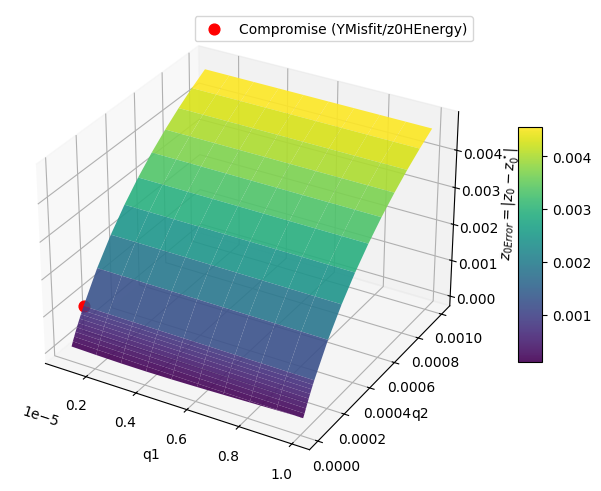

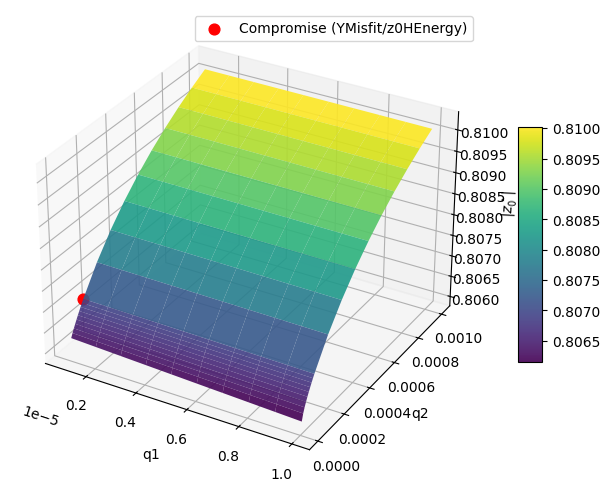

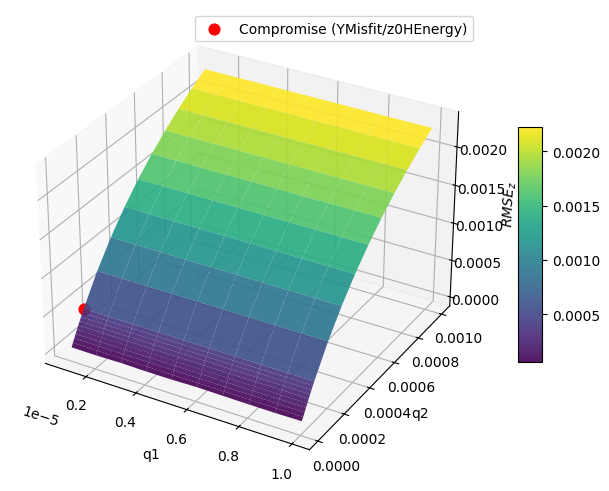

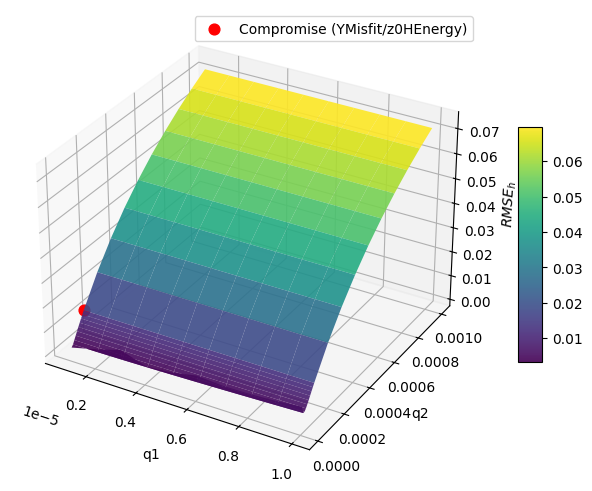

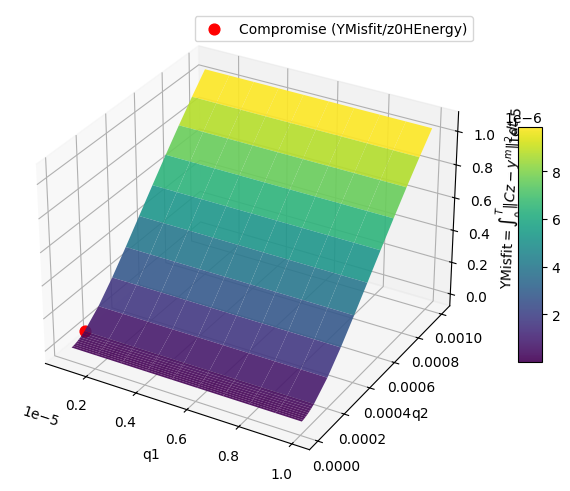

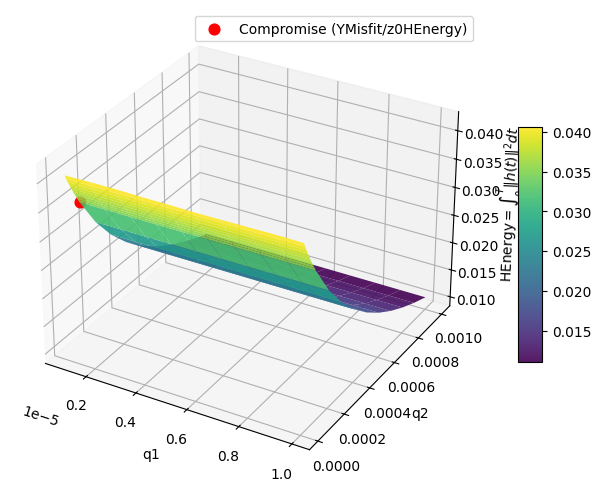

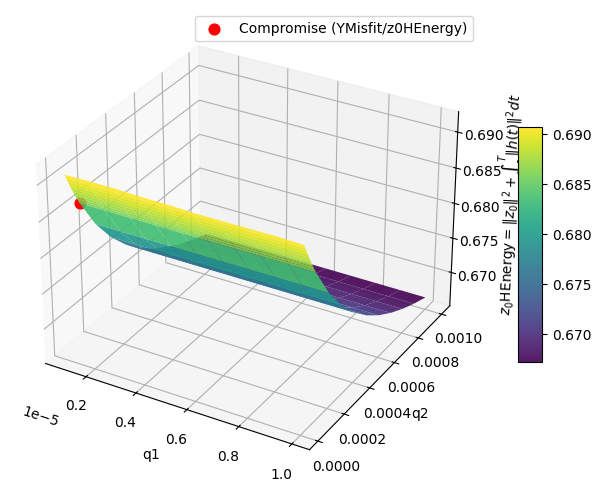

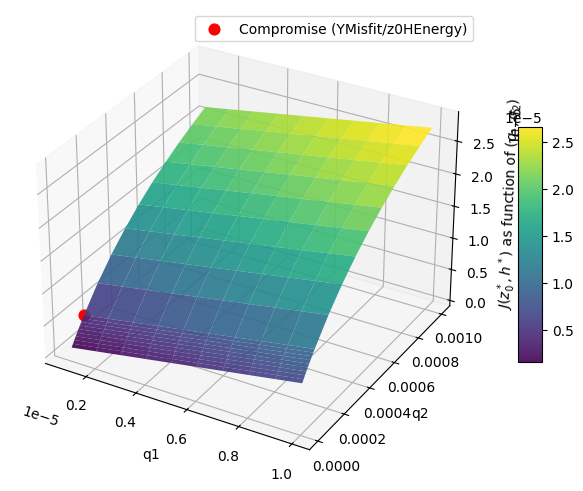

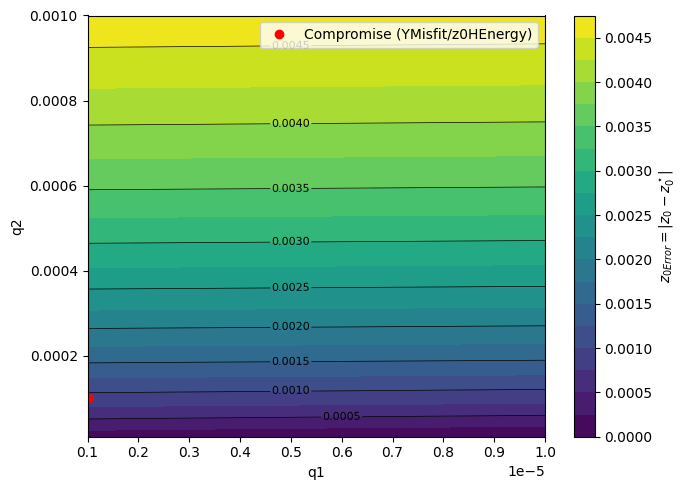

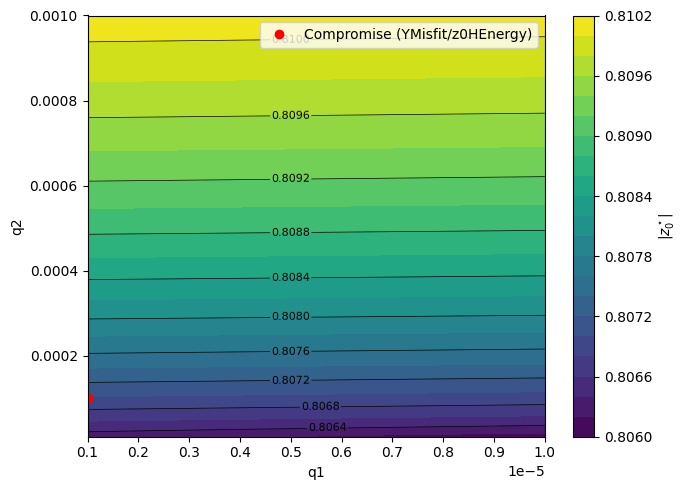

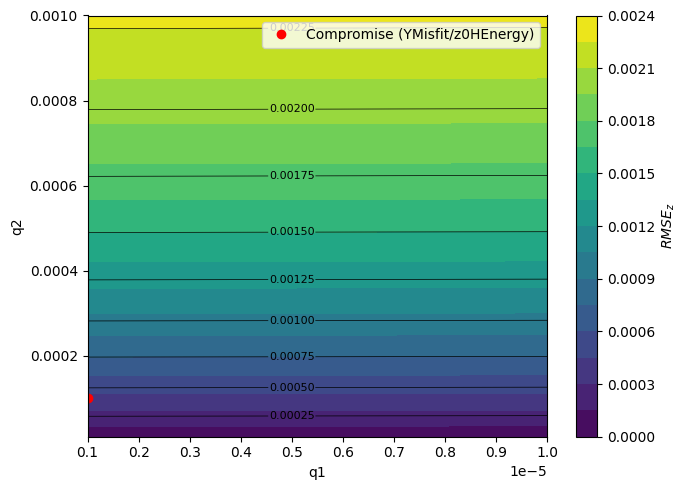

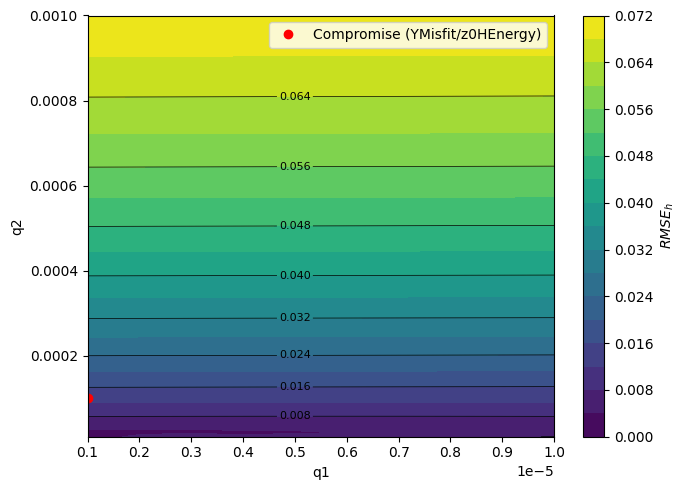

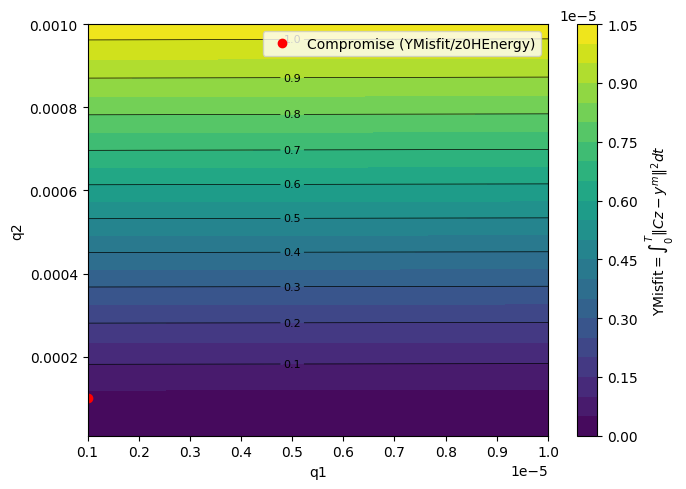

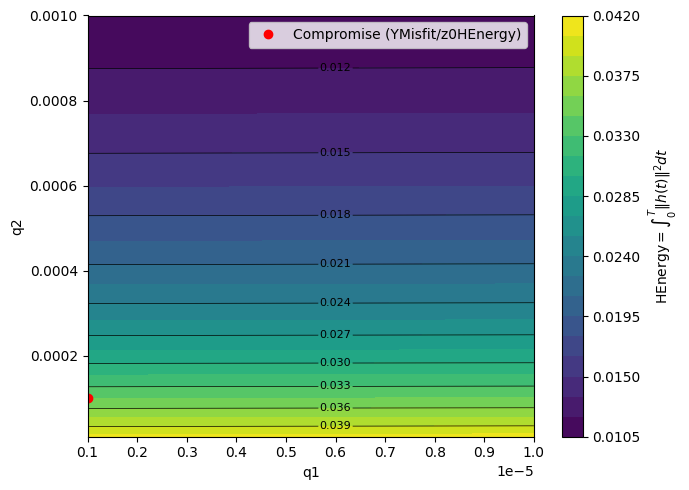

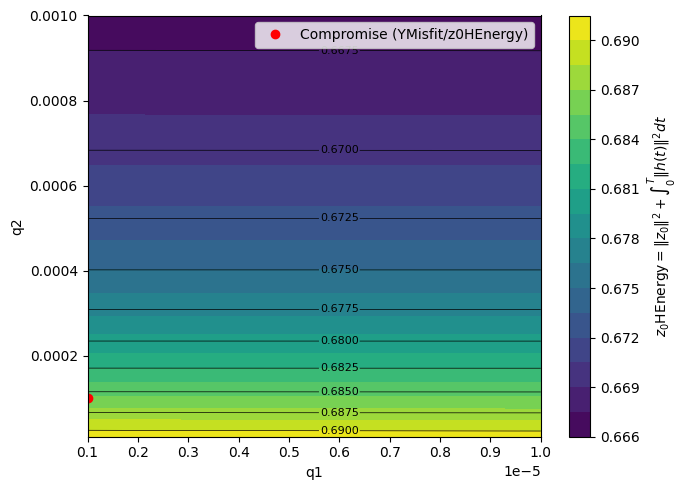

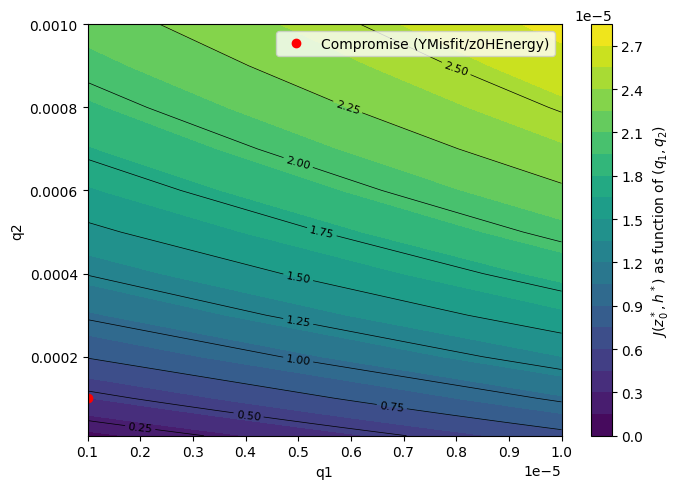

In [19]:
# Sensibility of q1 and q2: sweep q1 and q2, compute solutions & metrics, and search optimum q1 and q2 as L-curve compromise on YMisfit/HEnergy
# q1_vals = [0.001, 0.002, 0.005, 0.008, 0.01, 0.015, 0.02, 0.05, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]
# q2_vals = [0.25, 0.5, 1, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 7, 8, 8.25, 8.5, 8.75, 9, 9.25, 9.5, 9.75, 10, 10.25, 10.5, 10.75, 11, 20, 50, 100]

curves_z, curves_h, metrics, q1_opt, q2_opt = q12_sensibility_with_optimum(A, G2, C, z0, h1, h2, T=1, N=200, 
                                                                           q1_list=q1_vals, q2_list=q2_vals, elbow_on='misfit', save=False, outdir="figs")

===== Results with q1*=1e-06 and q2*=0.0001 =====
z0 true = [0.4 0.7], z0 estimated = [0.4008109  0.70040089], error = 0.0009045855409132743
RMSE_z    = 0.0004140989928815631
RMSE_h    = 0.013182431249389318
YMisfit   = 3.4069884198945286e-07
HEnergy   = 0.03449470477692537
z0Energy  = 0.03449470477692537


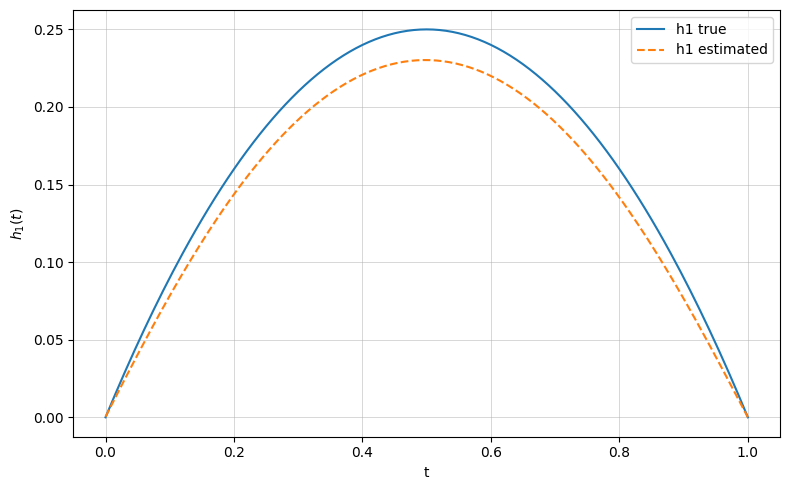

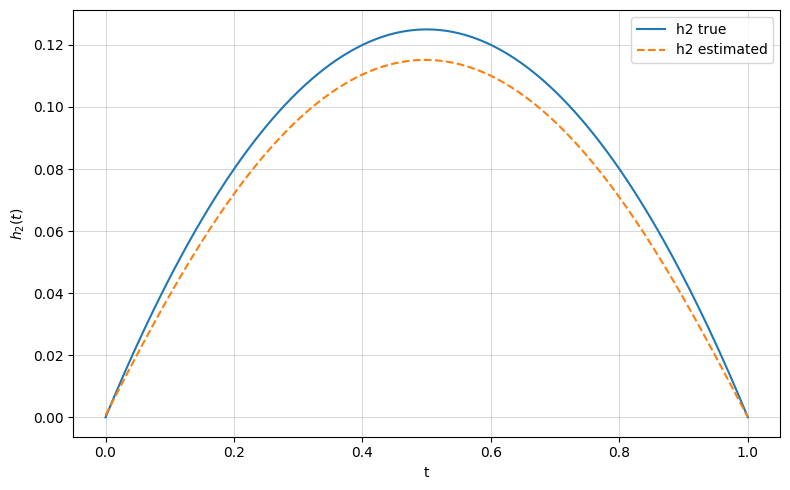

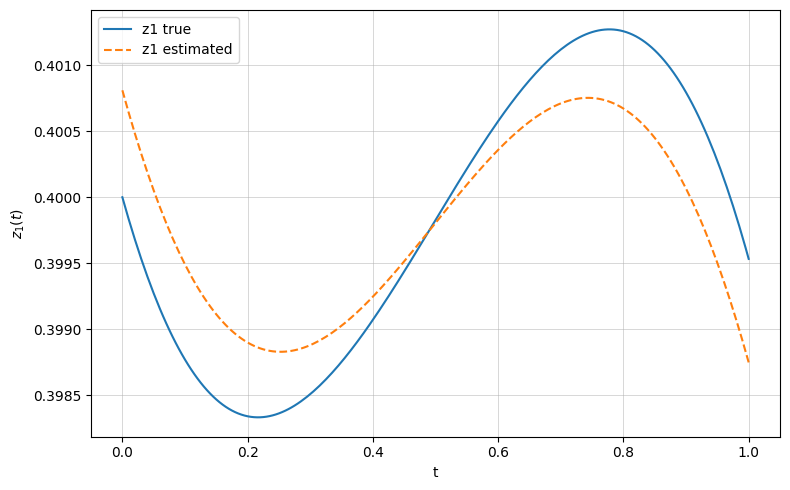

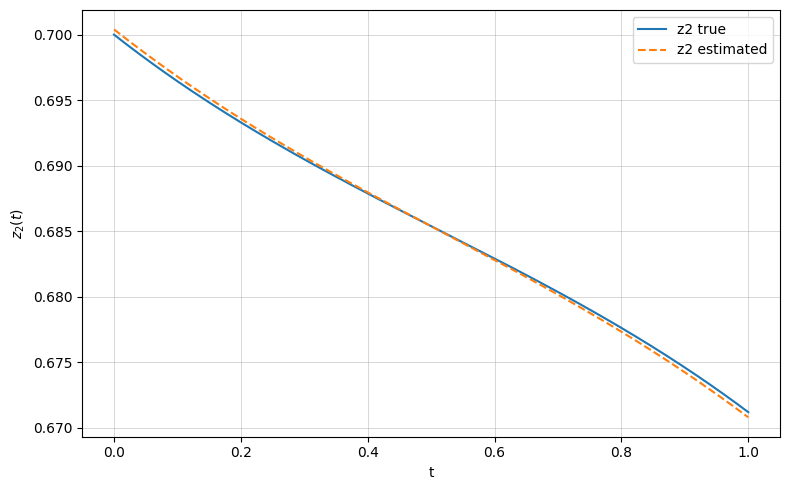

In [20]:
# Simulation for q1_opt and q2_opt (step 1 to 4)
h_true, z_true, y_m, z0_est, z_est, h_est = simulate_n2(A, G2, C, z0, h1, h2, T, N, q1_opt, q2_opt)

# Step 5: metrics
z0_error, z0_energy, z_rmse, h_rmse, misfit, energy = compute_metrics(C, z0, h_true, z_true, y_m, z0_est, z_est, h_est, t)
print(f"===== Results with q1*={q1_opt} and q2*={q2_opt} =====")
print(f"z0 true = {z0}, z0 estimated = {z0_est}, error = {z0_error}")
print(f"RMSE_z    = {z_rmse}")
print(f"RMSE_h    = {h_rmse}")
print(f"YMisfit   = {misfit}")
print(f"z0HEnergy = {z0_energy**2 + henergy}")
print(f"z0Energy  = {z0_energy}")
print(f"HEnergy   = {henergy}")

# Step 5: quick plots
make_plots(h_true, z_true, z_est, h_est, t, q1_opt, q2_opt, save=False, outdir = "figs")